In [1]:
# This is boilerplate code to correctly setup the settings to for notebook.
import os, sys
for root, dirs, files in os.walk(os.getcwd()):
    # print(root)

    if "pi0-analysis" in root.split("/"):
        pypath = root.split("pi0-analysis")[0] + "/pi0-analysis/analysis"
        print(pypath)
        break

sys.path.insert(0, pypath)

from python.analysis.NotebookUtils import init_notebook
%init_notebook

/home/suw//pi0-analysis/analysis
/home/suw//pi0-analysis/analysis
env: PYTHONPATH=/home/suw//pi0-analysis/analysis


In [2]:
import awkward as ak
import numpy as np

from iminuit import minimize
from python.analysis import cross_section, Tags, Plots, Master, vector, SelectionTools, BeamParticleSelection
from apps.cex_analysis_input import BeamPionSelection
from apps import cex_beam_reweight, cex_beam_scraper_fits
cross_section.PlotStyler.SetPlotStyle(extend_colors = True, dpi = 100)


In [3]:
args_pion = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("/home/suw/pi0-analysis/analysis/work/cex_analysis_2GeV_config.json"))

In [4]:
args_pion.ntuple_files["mc"][0]

{'file': '/data/dune/common/PDSPAnalyzer_Ntuples/PDSPProd4a_MC_2GeV_sce_datadriven_ntuple_v09_81_00d01_set0.root',
 'type': 'PDSPAnalyser',
 'pmom': 1}

In [5]:
file_names = {k : v[0]["file"] for k, v in args_pion.ntuple_files.items()}
samples_pion = {k : Master.Data(v, nTuple_type= args_pion.ntuple_files[k][0]["type"], target_momentum = args_pion.ntuple_files[k][0]["pmom"]) for k, v in file_names.items()}


/home/suw//pi0-analysis/analysis/python/analysis/Plots.py:897: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


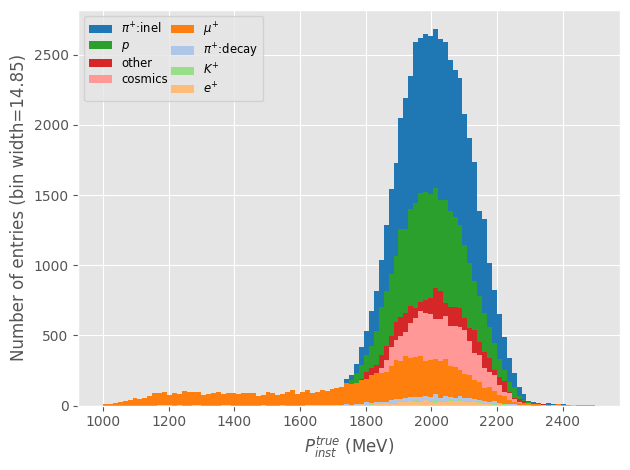

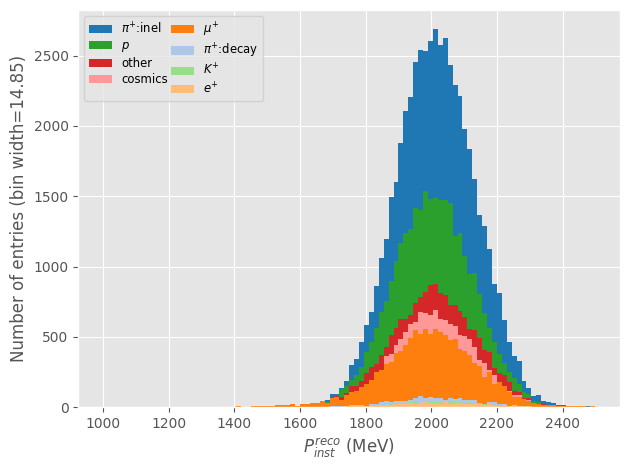

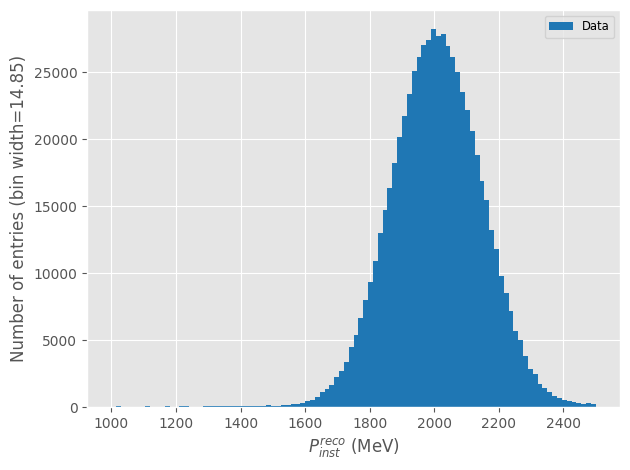

In [6]:
with Plots.PlotBook("2GeV_beam_momenta_profile.pdf", False) as book:
    Plots.PlotTagged(vector.magnitude(samples_pion["mc"].trueParticles.momentum[:, 0]), Tags.GenerateTrueBeamParticleTags(samples_pion["mc"]), y_scale = "linear", stacked = False, reverse_sort = True, x_range = args_pion.P_inst_range, x_label = "$P_{inst}^{true}$ (MeV)", loc = "upper left")
    book.Save()
    Plots.PlotTagged(samples_pion["mc"].recoParticles.beam_inst_P, Tags.GenerateTrueBeamParticleTags(samples_pion["mc"]), y_scale = "linear", stacked = False, reverse_sort = True, x_range = args_pion.P_inst_range, x_label = "$P_{inst}^{reco}$ (MeV)", loc = "upper left")
    book.Save()
    Plots.PlotHist(samples_pion["data"].recoParticles.beam_inst_P, range = args_pion.P_inst_range, xlabel = "$P_{inst}^{reco}$ (MeV)", label = "Data")
    book.Save()

# Sidebands

## Muons

In [ ]:
sideband_mc = (
          args_pion.selection_masks["mc"]["beam"]["PiBeamSelection"]
        & args_pion.selection_masks["mc"]["beam"]["PandoraTagCut"]
        & args_pion.selection_masks["mc"]["beam"]["CaloSizeCut"]
        & args_pion.selection_masks["mc"]["beam"]["DxyCut"]
        & args_pion.selection_masks["mc"]["beam"]["DzCut"]
        & args_pion.selection_masks["mc"]["beam"]["CosThetaCut"]
        & ~args_pion.selection_masks["mc"]["beam"]["APA3Cut"]
        & args_pion.selection_masks["mc"]["beam"]["HasFinalStatePFOsCut"])

sideband_data = (
        args_pion.selection_masks["data"]["beam"]["PiBeamSelection"]
        & args_pion.selection_masks["data"]["beam"]["PandoraTagCut"]
        & args_pion.selection_masks["data"]["beam"]["CaloSizeCut"]
        & args_pion.selection_masks["data"]["beam"]["DxyCut"]
        & args_pion.selection_masks["data"]["beam"]["DzCut"]
        & args_pion.selection_masks["data"]["beam"]["CosThetaCut"]
        & ~args_pion.selection_masks["data"]["beam"]["APA3Cut"]
        & args_pion.selection_masks["data"]["beam"]["HasFinalStatePFOsCut"])

muons = {
    "mc" : samples_pion["mc"].Filter([sideband_mc], [sideband_mc], True),
    "data" : samples_pion["data"].Filter([sideband_data], [sideband_data], True)
}

KeyError: 'PiBeamSelection'

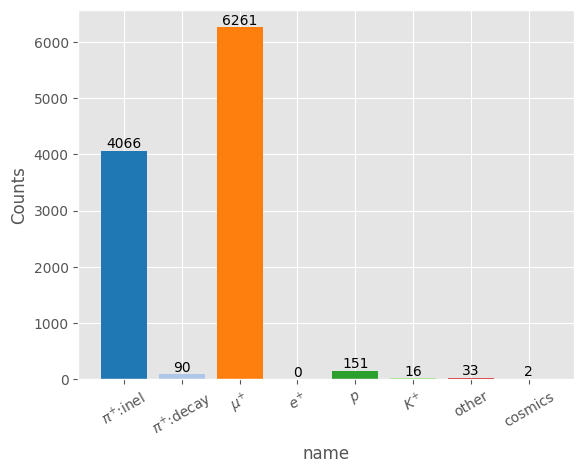

In [ ]:
Plots.PlotTags(Tags.GenerateTrueBeamParticleTags(muons["mc"]))

In [ ]:
reco_fractional_range = cex_beam_reweight.RecoFractionalRange(muons["mc"], cross_section.Particle.from_pdgid(-13), args_stopping_muon)
reco_fractional_range_data = cex_beam_reweight.RecoFractionalRange(muons["data"], cross_section.Particle.from_pdgid(-13), args_stopping_muon)

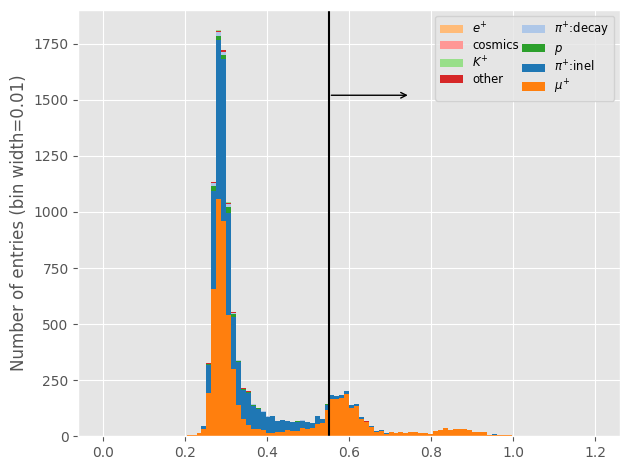

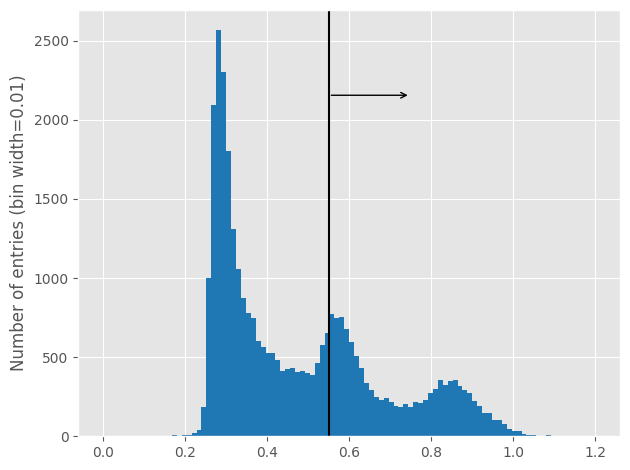

In [ ]:
Plots.PlotTagged(reco_fractional_range, Tags.GenerateTrueBeamParticleTags(muons["mc"]), x_range = [0, 1.2], y_scale = "linear")
Plots.DrawMultiCutPosition(0.55, face = ">")

Plots.PlotHist(reco_fractional_range_data, range = [0, 1.2])
Plots.DrawMultiCutPosition(0.55, face = ">")

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_inst_P.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_calo_pos.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_track_length.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Docume

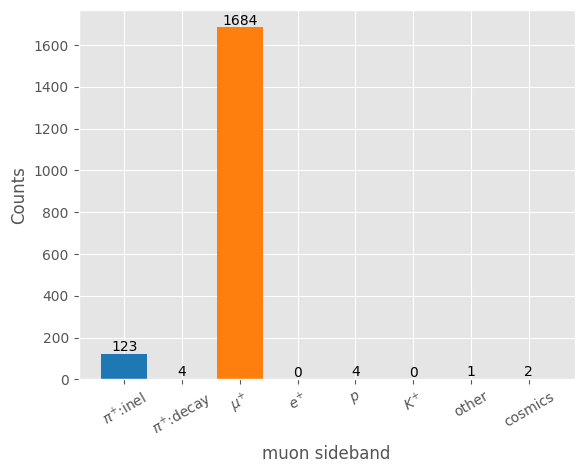

In [ ]:
range_mask = {"mc" : reco_fractional_range > 0.55, "data" : reco_fractional_range_data > 0.55}
muons = {k : v.Filter([range_mask[k]], [range_mask[k]], True) for k, v in muons.items()}

pdf muon_sideband.pdf has been opened
pdf muon_sideband.pdf has been closed


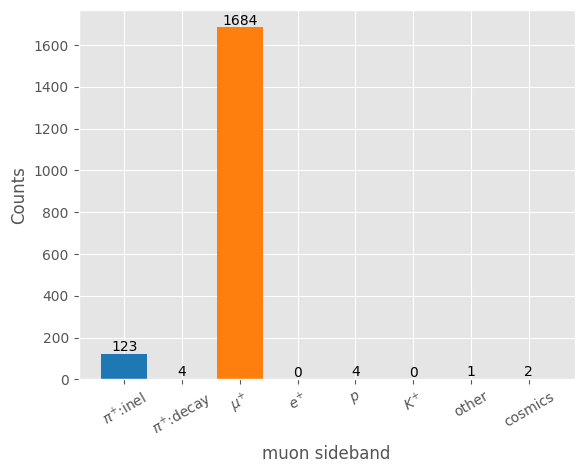

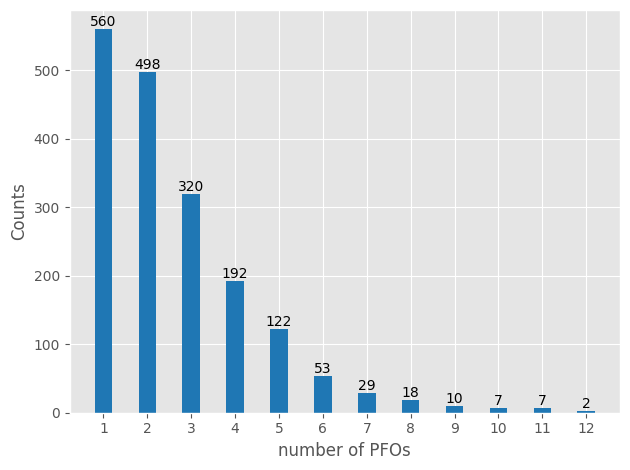

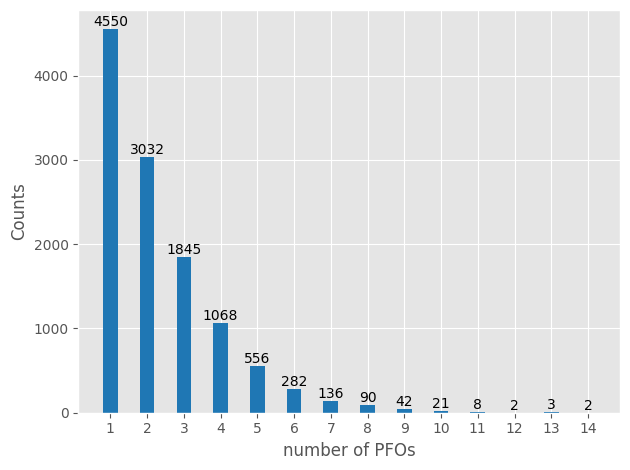

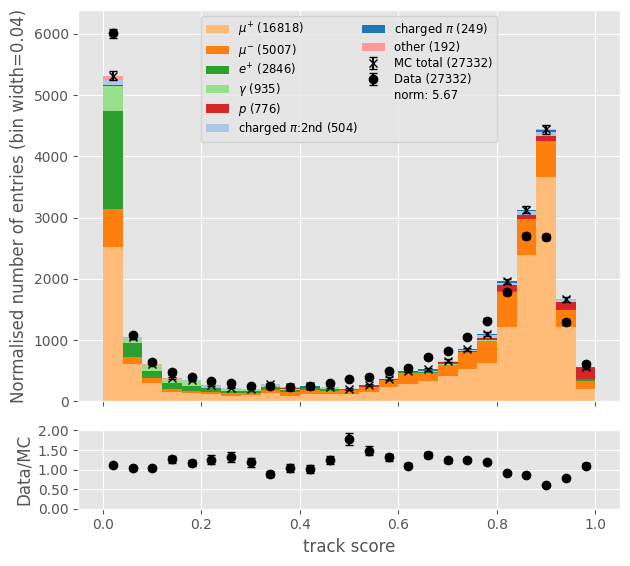

In [ ]:
with Plots.PlotBook("muon_sideband.pdf", True) as book:
    Plots.PlotTags(Tags.GenerateTrueBeamParticleTags(muons["mc"]), xlabel = "muon sideband")
    book.Save()
    Plots.PlotBar(ak.num(muons["mc"].recoParticles.number), xlabel = "number of PFOs")
    book.Save()
    Plots.PlotBar(ak.num(muons["data"].recoParticles.number), xlabel = "number of PFOs")
    book.Save()
    Plots.PlotTagged(muons["mc"].recoParticles.track_score, Tags.GenerateTrueParticleTagsPiPlus(muons["mc"]), data2 = muons["data"].recoParticles.track_score, x_range = [0, 1], bins = 25, norm = True, x_label = "track score")
    book.Save()


## Protons

In [ ]:
book = Plots.PlotBook("1GeV_proton_selection.pdf", False)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1285: RuntimeWarning: divide by zero encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1285: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1286: RuntimeWarning: invalid value encountered in divide
  ra

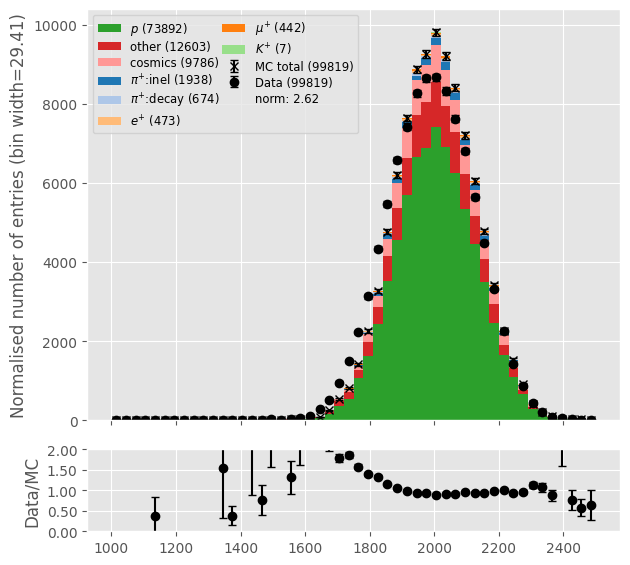

In [ ]:
proton_mask = {"mc" : cross_section.BeamParticleSelection.BeamTriggerSelection(samples_pion["mc"], [2212], False), "data" : cross_section.BeamParticleSelection.BeamTriggerSelection(samples_pion["data"], [2212], True)}
proton_sample  = {k : v.Filter([proton_mask[k]],[proton_mask[k]], returnCopy = True) for k, v in samples_pion.items()}
Plots.PlotTagged(proton_sample["mc"].recoParticles.beam_inst_P, cross_section.Tags.GenerateTrueBeamParticleTags(proton_sample["mc"]), data2 = proton_sample["data"].recoParticles.beam_inst_P, x_range = args_pion.P_inst_range, bins = 50, norm = True)
book.Save()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


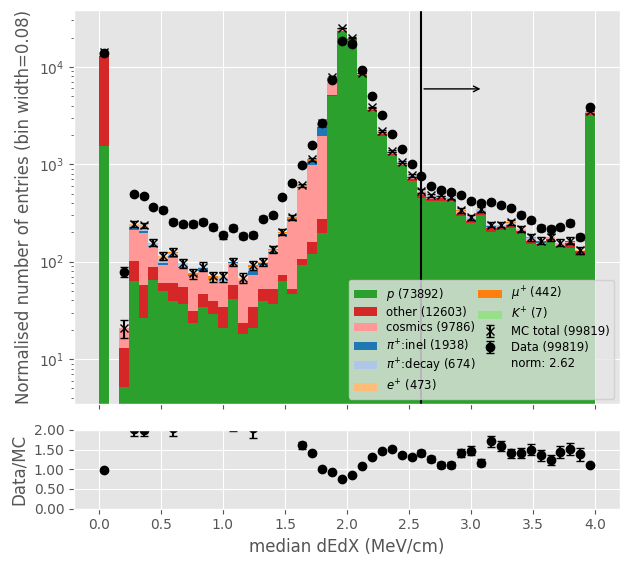

In [ ]:
Plots.PlotTagged(cross_section.BeamParticleSelection.Median(proton_sample["mc"].recoParticles.beam_dEdX), Tags.GenerateTrueBeamParticleTags(proton_sample["mc"]), data2 = cross_section.BeamParticleSelection.Median(proton_sample["data"].recoParticles.beam_dEdX), x_range = [0, 4], y_scale = "log", truncate = True, x_label = "median dEdX (MeV/cm)", norm = True, bins = 50)
Plots.DrawMultiCutPosition(2.6, face = ">", arrow_length = 0.5)
book.Save()
book.close()

In [ ]:
proton_mask = {k : cross_section.BeamParticleSelection.Median(v.recoParticles.beam_dEdX) > 2.6 for k, v in proton_sample.items()}
proton_sample  = {k : v.Filter([proton_mask[k]],[proton_mask[k]], returnCopy = True) for k, v in proton_sample.items()}


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


In [ ]:
proton_mask = {k : cross_section.BeamParticleSelection.HasFinalStatePFOsCut(v) for k, v in proton_sample.items()}
proton_sample = {k : v.Filter([proton_mask[k]], [proton_mask[k]], returnCopy = True) for k, v in proton_sample.items()}

proton_sample = {k : v.Filter([cross_section.PFOSelection.GoodShowerSelection(v)], returnCopy = True) for k, v in proton_sample.items()}

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_inst_P.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_dEdX.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _TrueParticleDataBT__beam_pdg.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _TrueParticleDataBT__beam_endProcess.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _TrueParticleDataBT__beam_origin.
  warnings.warn(f"Couldn't apply filters to {var

In [ ]:
proton_sample["mc"].recoParticles.LoadData("beam_track_score", "reco_beam_PFP_trackScore", False)
proton_sample["data"].recoParticles.LoadData("beam_track_score", "reco_beam_PFP_trackScore", False)

pdf 1GeV_proton_sideband.pdf has been opened
pdf 1GeV_proton_sideband.pdf has been closed


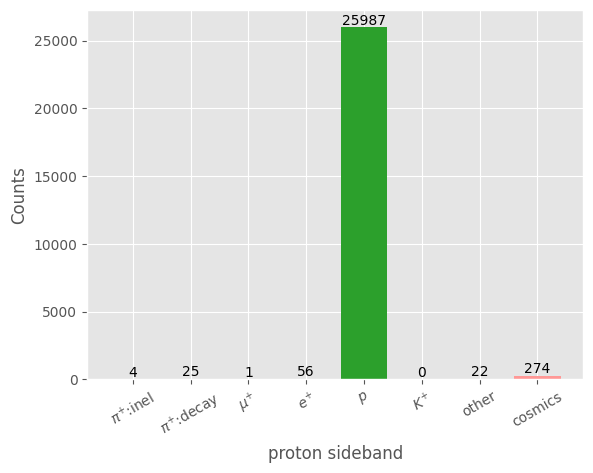

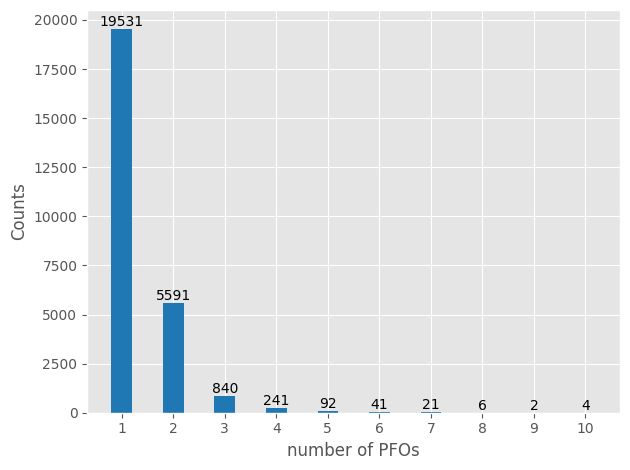

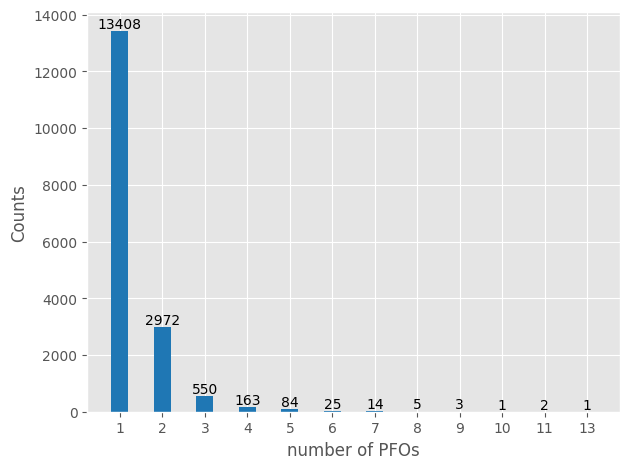

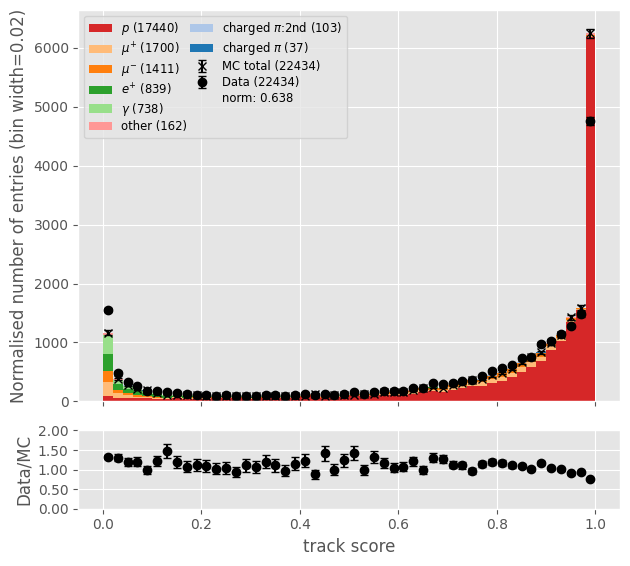

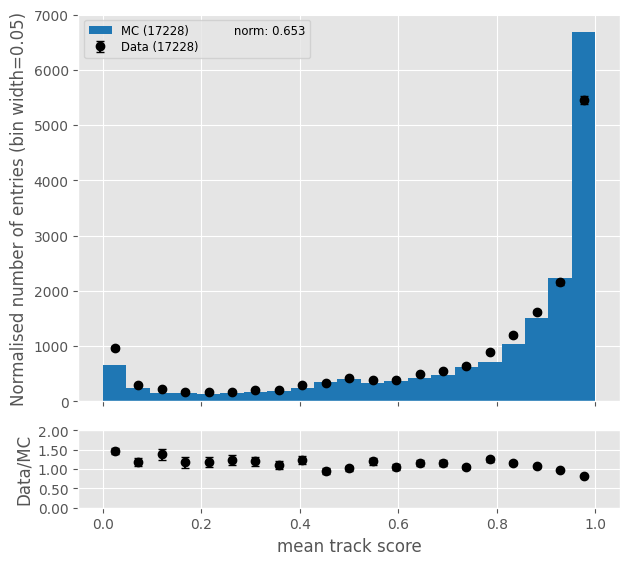

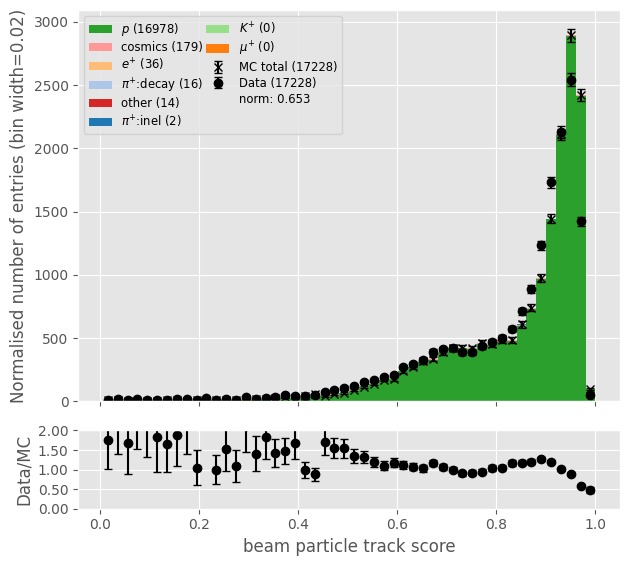

In [ ]:
with Plots.PlotBook("1GeV_proton_sideband.pdf", True) as book:
    Plots.PlotTags(Tags.GenerateTrueBeamParticleTags(proton_sample["mc"]), xlabel = "proton sideband")
    book.Save()
    Plots.PlotBar(ak.num(proton_sample["mc"].recoParticles.number), xlabel = "number of PFOs")
    book.Save()
    Plots.PlotBar(ak.num(proton_sample["data"].recoParticles.number), xlabel = "number of PFOs")
    book.Save()
    Plots.PlotTagged(proton_sample["mc"].recoParticles.track_score, Tags.GenerateTrueParticleTagsPiPlus(proton_sample["mc"]), data2 = proton_sample["data"].recoParticles.track_score, x_range = [0, 1], bins = 50, norm = True, x_label = "track score")
    book.Save()
    Plots.PlotHistDataMC(ak.mean(proton_sample["data"].recoParticles.track_score, axis = -1), ak.mean(proton_sample["mc"].recoParticles.track_score, axis = -1), x_range = [0, 1], bins = 21, norm = True, xlabel = "mean track score")
    book.Save()
    Plots.PlotTagged(proton_sample["mc"].recoParticles._RecoParticleData__beam_track_score, Tags.GenerateTrueBeamParticleTags(proton_sample["mc"]), data2 = proton_sample["data"].recoParticles._RecoParticleData__beam_track_score, norm = True, bins = 50, x_label = "beam particle track score")
    book.Save()


## mean track score reweight

In [ ]:
def MeanTrackScoreWeights(mc : Master.Data, func : cross_section.Fitting.FitFunction, params : list, truncate : int = 10):
    weights = 1/func(ak.mean(mc.recoParticles.track_score, axis = -1), *params)
    weights = np.where(weights > truncate, truncate, weights)
    return weights

pdf 1GeV_mean_track_score_reweight.pdf has been opened
pdf 1GeV_mean_track_score_reweight.pdf has been closed


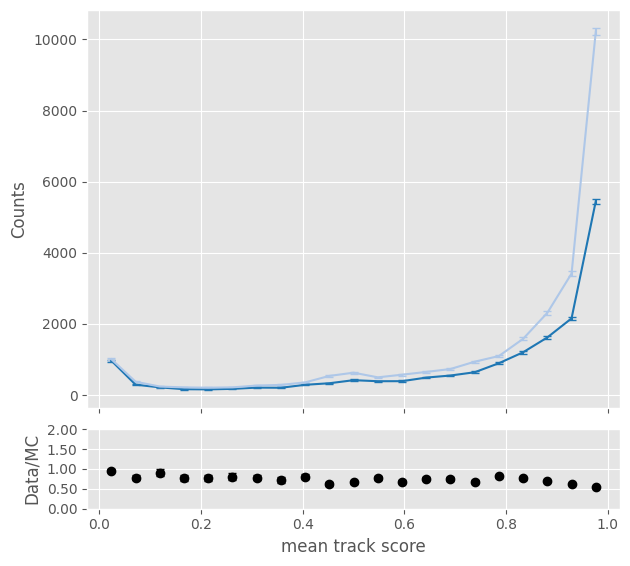

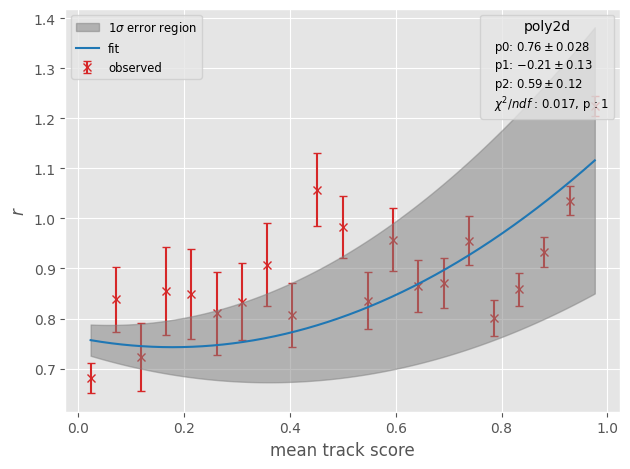

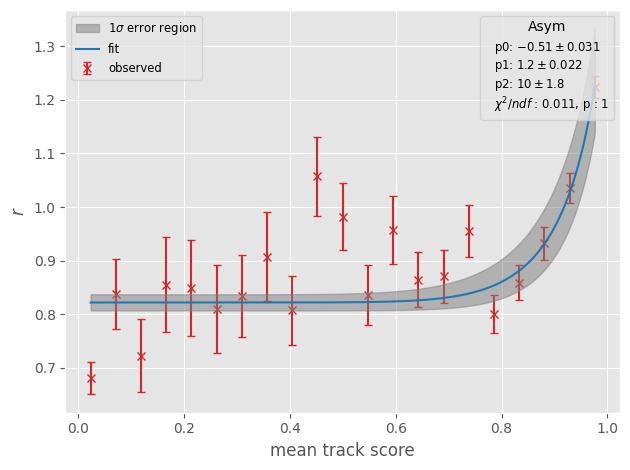

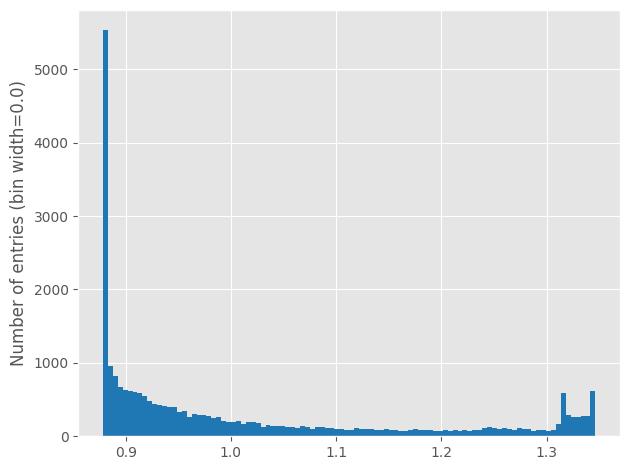

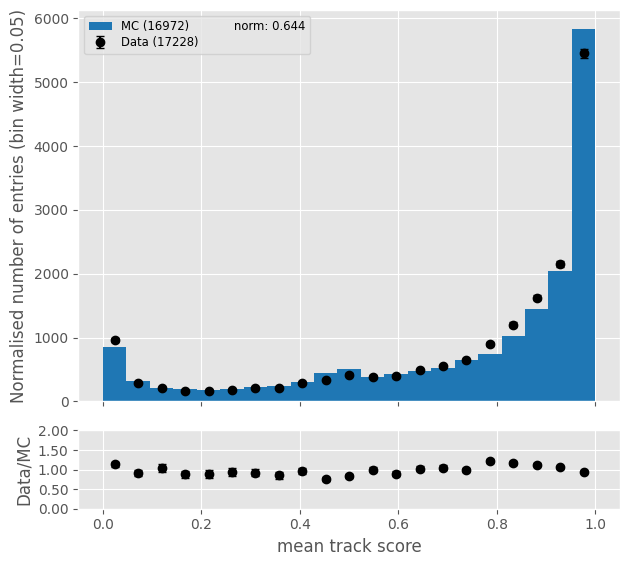

In [ ]:
with Plots.PlotBook("1GeV_mean_track_score_reweight", True) as book:
    s_mc, edges = np.histogram(np.array(ak.mean(proton_sample["mc"].recoParticles.track_score, axis = -1)), 21, [0, 1])
    s_data = np.histogram(np.array(ak.mean(proton_sample["data"].recoParticles.track_score, axis = -1)), 21, [0, 1])[0]

    with Plots.RatioPlot((edges[1:] + edges[:-1]) / 2, s_data, s_mc, np.sqrt(s_data), np.sqrt(s_mc), "mean track score", "Data/MC") as ratio_plot:
        Plots.Plot(ratio_plot.x, ratio_plot.y1, yerr = ratio_plot.y1_err, newFigure = False)
        Plots.Plot(ratio_plot.x, ratio_plot.y2, yerr = ratio_plot.y2_err, newFigure = False, ylabel = "Counts")
    book.Save()
    scale = sum(ratio_plot.y1) / sum(ratio_plot.y2)
    ratio = scale * np.nan_to_num(ratio_plot.y2/ratio_plot.y1, posinf = 0)
    ratio_err = np.nan_to_num(abs(ratio * np.sqrt((ratio_plot.y1_err/ratio_plot.y1)**2 + (ratio_plot.y2_err/ratio_plot.y2)**2)))

    Plots.plt.figure()
    fit_result_poly2d = cross_section.Fitting.Fit(ratio_plot.x, ratio, ratio_err, cross_section.Fitting.poly2d, plot = True, xlabel = "mean track score", ylabel = "$r$")
    book.Save()

    Plots.plt.figure()
    fit_result_asym = cross_section.Fitting.Fit(ratio_plot.x, ratio, ratio_err, Asym, plot = True, xlabel = "mean track score", ylabel = "$r$")
    book.Save()

    weights = np.array(MeanTrackScoreWeights(proton_sample["mc"], cross_section.Fitting.poly2d, fit_result_poly2d[0]))
    Plots.PlotHist(weights)
    book.Save()

    Plots.PlotHistDataMC(ak.mean(proton_sample["data"].recoParticles.track_score, axis = -1), ak.mean(proton_sample["mc"].recoParticles.track_score, axis = -1), x_range = [0, 1], bins = 21, norm = True, xlabel = "mean track score", mc_weights = weights)
    book.Save()


In [ ]:
print(f"{sum(weights)=}")
print(f"{len(weights)=}")

sum(weights)=26765.220556419827
len(weights)=26369


In [ ]:
cross_section.SaveConfiguration("test/1GeV_track_score_reweight_params.json", {f"p{i}" : {"value" : fit_result_poly2d[0][i], "error" : fit_result_poly2d[1][i]} for i in range(cross_section.Fitting.poly2d.n_params)})


## Pion

In [256]:
file_names["data"]

'/data/dune/common/PDSPAnalyzer_Ntuples/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01.root'

In [208]:
args_pion.selection_masks['mc']['beam'][file_names["mc"]].items()

dict_items([('TrueFiducialCut', <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>), ('PiBeamSelection', <Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>), ('PandoraTagCut', <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>), ('CaloSizeCut', <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>), ('HasFinalStatePFOsCut', <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>), ('APA3Cut', <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>), ('DxyCut', <Array [True, False, True, True, ..., True, True, False] type='52654 * ?bool'>), ('CosThetaCut', <Array [True, True, True, True, ..., True, True, False] type='52654 * ?bool'>), ('BeamScraperCut', <Array [True, True, True, True, ..., True, True, False] type='52654 * bool'>)])

In [7]:
def plot_accept_reject(selection : str, samples_pion : dict[Master.Data]):

    selection_mask = {k : np.ones(len(v.eventNum), dtype = bool) for k, v in samples_pion.items()}
    rejection_mask = {k : np.ones(len(v.eventNum), dtype = bool) for k, v in samples_pion.items()}


    for s, d, m in zip(args_pion.selection_masks["mc"][selection][file_names["mc"]].keys(), args_pion.selection_masks["data"][selection][file_names["data"]].values(), args_pion.selection_masks["mc"][selection][file_names["mc"]].values()):
        # if s == "BeamScraperCut":
        #     # Invert the cut for BeamScraperCut
        #     rejection_mask["data"] = selection_mask["data"] & d
        #     rejection_mask["mc"] = selection_mask["mc"] & m

        #     selection_mask["data"] = selection_mask["data"] & ~d
        #     selection_mask["mc"] = selection_mask["mc"] & ~m
        # else:
            # Normal cut logic
        rejection_mask["data"] = selection_mask["data"] & ~d
        rejection_mask["mc"] = selection_mask["mc"] & ~m

        selection_mask["data"] = selection_mask["data"] & d
        selection_mask["mc"] = selection_mask["mc"] & m
            

        if (sum(rejection_mask["mc"]) > 0) and (sum(rejection_mask["data"]) > 0):
            samples_pion_selection = {k : v.Filter([rejection_mask[k]], [rejection_mask[k]], returnCopy = True) for k, v in samples_pion.items()}
            Plots.PlotTagged(samples_pion_selection["mc"].recoParticles.beam_inst_P, cross_section.Tags.GenerateTrueBeamParticleTags(samples_pion_selection["mc"]), data2 = samples_pion_selection["data"].recoParticles.beam_inst_P, x_range = [1500, 2500], norm = True, loc = "upper left", bins = 50, ncols = 1, title = f"{s} : rejected")
        else:
            print(f"no samples rejected for selection {s}")

        if (sum(selection_mask["mc"]) > 0) and (sum(selection_mask["data"]) > 0):
            samples_pion_selection = {k : v.Filter([selection_mask[k]], [selection_mask[k]], returnCopy = True) for k, v in samples_pion.items()}
            Plots.PlotTagged(samples_pion_selection["mc"].recoParticles.beam_inst_P, cross_section.Tags.GenerateTrueBeamParticleTags(samples_pion_selection["mc"]), data2 = samples_pion_selection["data"].recoParticles.beam_inst_P, x_range = [1500, 2500], norm = True, loc = "upper left", bins = 50, ncols = 1, title = f"{s} : accepted")
        else:
            print(f"no samples accepted for selection {s}")
    return


no samples rejected for selection TrueFiducialCut
f=<Array [True, False, True, True, ..., True, True, False] type='131266 * bool'>
f=<Array [True, True, True, True, ..., True, True, True] type='1349399 * bool'>
f=<Array [False, False, False, ..., True, False, False] type='131266 * bool'>
f=<Array [True, True, True, True, ..., True, False, True] type='1349399 * bool'>
f=<Array [True, False, True, True, ..., False, True, False] type='131266 * bool'>
f=<Array [False, False, False, ..., False, True, False] type='1349399 * bool'>


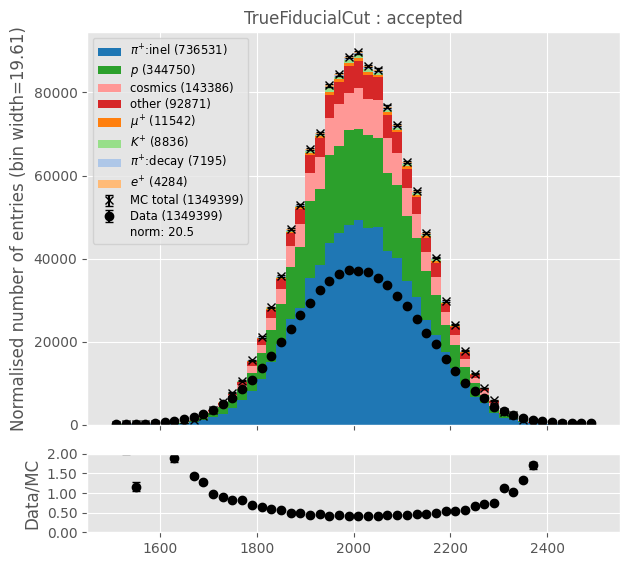

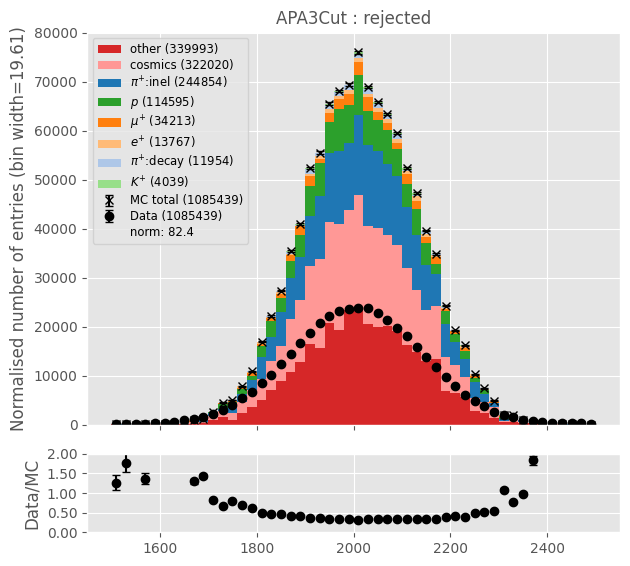

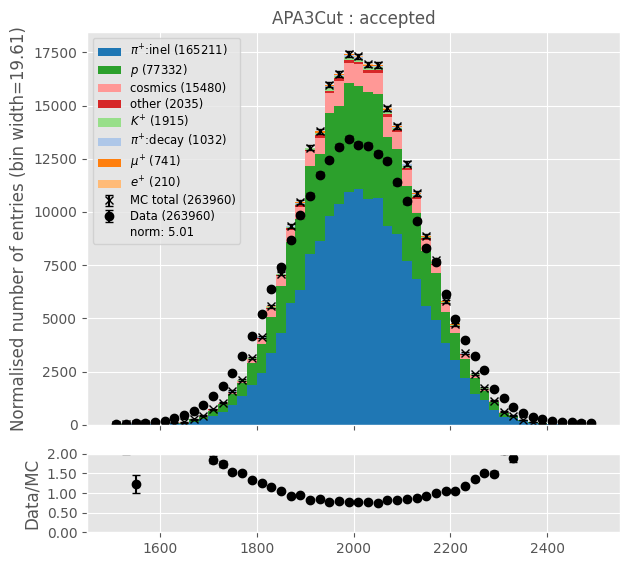

In [8]:
# accept reject for fiducial cuts
plot_accept_reject("fiducial", samples_pion)

In [9]:
# apply fiducial selection
#! it would be good to make this a function you can call from cex_analysis_input.
masks = {k : SelectionTools.CombineMasks(args_pion.selection_masks[k]["fiducial"][file_names[k]]) for k in samples_pion}
{k : v.Filter([masks[k]], [masks[k]], returnCopy = True) for k, v in samples_pion.items()}
filtered_samples = {k : v.Filter([masks[k]], [masks[k]], returnCopy = True) for k, v in samples_pion.items()}

f=<Array [True, False, True, True, ..., False, True, False] type='131266 * bool'>
f=<Array [False, False, False, ..., False, True, False] type='1349399 * bool'>
f=<Array [True, False, True, True, ..., False, True, False] type='131266 * bool'>
f=<Array [False, False, False, ..., False, True, False] type='1349399 * bool'>


## Plots

In [28]:
import matplotlib.pyplot as plt
import numpy as np


def BeamScraperPlots(beam_inst_KE_bins : list, output_mc : dict[ak.Array], scraper_fits : dict) -> dict:
    """ Scatter plots of events to show beam scraper events as a function of the XY position at the beam instrumentation.

    Args:
        mc (Master.Data): events to look at.
        beam_inst_KE_bins (list): beam kinetic energy bins.
        beam_inst_KE (ak.Array): beam instrumentation kinetic energy.
        delta_KE_upstream (ak.Array): difference in the front facing KE and beam kinetic energy.
        scraper_fits (dict): parameters to define beam scrapers.

    Returns:
        dict: mean and standard deviations of the positions
    """

    output = {}
    

    for i in Plots.MultiPlot(len(beam_inst_KE_bins)-1):
        if i == len(beam_inst_KE_bins): continue
        bin_edges = (beam_inst_KE_bins[i], beam_inst_KE_bins[i+1])
        bin_label = "$KE^{reco}_{inst}$:" + f"[{beam_inst_KE_bins[i]},{beam_inst_KE_bins[i+1]}] (MeV)"
        e = (output_mc["beam_inst_KE"] < beam_inst_KE_bins[i+1]) & (output_mc["beam_inst_KE"] > beam_inst_KE_bins[i])
        fit_values = scraper_fits[(beam_inst_KE_bins[i], beam_inst_KE_bins[i+1])]

        is_scraper = output_mc["delta_KE_upstream"][e] > (fit_values["mu_e_res"] + 3 * fit_values["sigma_e_res"])

        Plots.Plot(output_mc["beam_inst_x"][e][~is_scraper], output_mc["beam_inst_y"][e][~is_scraper], newFigure = False, linestyle = "", marker = "o", markersize = 2, color = "C0", alpha = 0.5, label = "non-scraper", rasterized = True)
        Plots.Plot(output_mc["beam_inst_x"][e][is_scraper], output_mc["beam_inst_y"][e][is_scraper], newFigure = False, linestyle = "", marker = "o", markersize = 2, color = "C6", alpha = 0.5, label = "scraper", rasterized = True)

        mu_x = ak.mean(output_mc["beam_inst_x"][e])
        mu_y = ak.mean(output_mc["beam_inst_y"])
        print(bin_label)
        print(mu_x, mu_y)
        sigma_x = ak.std(output_mc["beam_inst_x"][e])
        sigma_y = ak.std(output_mc["beam_inst_y"])

        output[bin_edges] = {"mu_x_inst" : mu_x, "mu_y_inst" : mu_y, "sigma_x_inst" : sigma_x, "sigma_y_inst" : sigma_y}

        theta = np.linspace(0, 2*np.pi, 100)
        for j, m in enumerate([0.5, 1, 1.5, 2, 3]):
            r = m * (sigma_x**2 + sigma_y**2)**0.5
            x = r*np.cos(theta) + mu_x
            y = r*np.sin(theta) + mu_y

            Plots.Plot(x, y, linestyle = "--", color = f"C{7+j}", alpha = 1, label = f"{m}$r_{{inst}}$", newFigure = False)

        a = 1.6
        b = 455.0

        a2 = 1.57
        b2 = 482.8

        x_min, x_max = -45, -15
        x_line = np.linspace(x_min, x_max, 200)
        y_line = a * x_line + b

        y_line2 = a2 * x_line + b2

        Plots.Plot(
            x_line,
            y_line,
            linestyle="--",
            color="k",
            label = r"$y = {a}x + {b}$".format(a = a, b = b),
            newFigure = False)
        Plots.Plot(
            x_line,
            y_line2,
            linestyle="--",
            color="g",
            label = r"$y = {a}x + {b}$".format(a = a2, b = b2),
            newFigure = False)
            
        plt.xlabel("$X^{reco}_{inst}$ (cm)")
        plt.ylabel("$Y^{reco}_{inst}$ (cm)")
        plt.title(bin_label)
        plt.xlim(-50, -10)
        plt.ylim(405, 440)
        plt.gca().set_aspect("equal", adjustable="box")        
        plt.legend()

            
    return output

In [11]:
args_pion.selection_masks["mc"]["beam"][file_names["mc"]]

{'TrueFiducialCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'PiBeamSelection': <Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>,
 'PandoraTagCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'CaloSizeCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'HasFinalStatePFOsCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'APA3Cut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'DxyCut': <Array [True, False, True, True, ..., True, True, False] type='52654 * ?bool'>,
 'CosThetaCut': <Array [True, True, True, True, ..., True, True, False] type='52654 * ?bool'>,
 'BeamScraperCut': <Array [True, True, True, True, ..., True, True, False] type='52654 * bool'>}

In [29]:
from apps import cex_beam_scraper_fits
from particle import Particle


def run(samples : dict[Master.Data], args : dict):
    mc = samples['mc']
    for k, v in args['beam'][file_names["mc"]].items():
        if k == "BeamScraperCut": break  
        mc.Filter([v], [v])
        print(f"{k} : {len(mc.eventNum)=}")


    beam_inst_KE = cross_section.KE(mc.recoParticles.beam_inst_P, Particle.from_pdgid(211).mass) # get kinetic energy from beam instrumentation
    true_ffKE = mc.trueParticles.beam_KE_front_face

    beam_inst_x = mc.recoParticles.beam_inst_pos.x
    beam_inst_y = mc.recoParticles.beam_inst_pos.y

    delta_KE_upstream = beam_inst_KE - true_ffKE

    return {"beam_inst_KE" : beam_inst_KE, "true_ffKE" : true_ffKE, "beam_inst_x" : beam_inst_x, "beam_inst_y" : beam_inst_y, "delta_KE_upstream" : delta_KE_upstream}



f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
TrueFiducialCut : len(mc.eventNum)=36347
f=<Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>
PiBeamSelection : len(mc.eventNum)=36347
f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
PandoraTagCut : len(mc.eventNum)=36347
f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
CaloSizeCut : len(mc.eventNum)=36347
f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
HasFinalStatePFOsCut : len(mc.eventNum)=36347
f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
APA3Cut : len(mc.eventNum)=36347
f=<Array [True, False, True, True, ..., True, True, False] type='52654 * ?bool'>
DxyCut : len(mc.eventNum)=36347
f=<Array [True, True, True, True, ..., True, True, False] type='52654 * ?bool'>
CosThetaCut : len(mc.eventNum)=36347


(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(80), np.float64(2.990595008768196), 
np.float64(81.48451438501657))

[[ 3.67673319  0.41631066 -1.0607861 ]
 [ 0.41631066  1.69314281 -0.9113392 ]
 [-1.0607861  -0.9113392   1.08405267]]


popt=array([64.94077965, -2.59709406, 32.16184759])

perr=array([1.91748095, 1.30120821, 1.0411785 ])

(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(409), np.float64(13.076002051045634), 
np.float64(56.28162026704296))

[[19.42205338  0.15126394 -1.94738819]
 [ 0.15126394  0.19609942 -0.04867694]
 [-1.94738819 -0.04867694  0.40148729]]


popt=array([383.21558946,  11.8033969 ,  35.83208861])

perr=array([4.40704588, 0.44283114, 0.63363025])

(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(309), np.float64(29.641917977365893), 
np.float64(57.312895420872884))

[[14.61220803  0.14097735 -2.34913713]
 [ 0.14097735  0.34529108 -0.07179537]
 [-2.34913713 -0.07179537  0.76965732]]


popt=array([291.78574421,  28.65371835,  40.80425537])

perr=array([3.82259179, 0.58761474, 0.87730116])

(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(33), np.float64(68.8824548785592), 
np.float64(112.50928301299957))

[[ 1.10771999  0.38447368 -1.39775802]
 [ 0.38447368  3.74750629 -1.92254308]
 [-1.39775802 -1.92254308  4.2932956 ]]


popt=array([21.97119649, 64.50914015, 35.27680713])

perr=array([1.05248278, 1.93584769, 2.07202693])

$KE^{reco}_{inst}$:[1500,1700] (MeV)
-29.798991713894484 421.80540770124196
$KE^{reco}_{inst}$:[1700,1900] (MeV)
-29.596385239808225 421.80540770124196
$KE^{reco}_{inst}$:[1900,2100] (MeV)
-28.39640754882066 421.80540770124196
$KE^{reco}_{inst}$:[2100,2300] (MeV)
-26.962449949765876 421.80540770124196


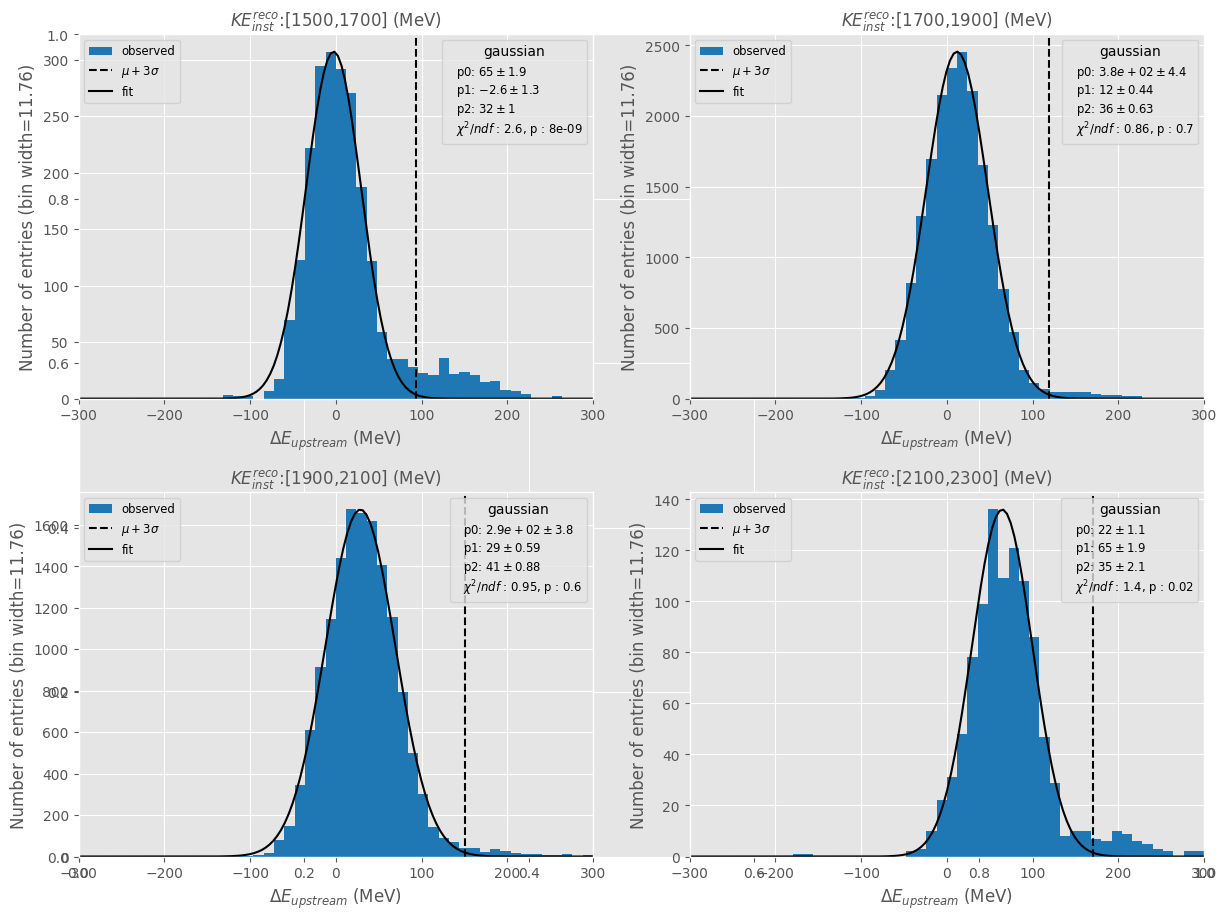

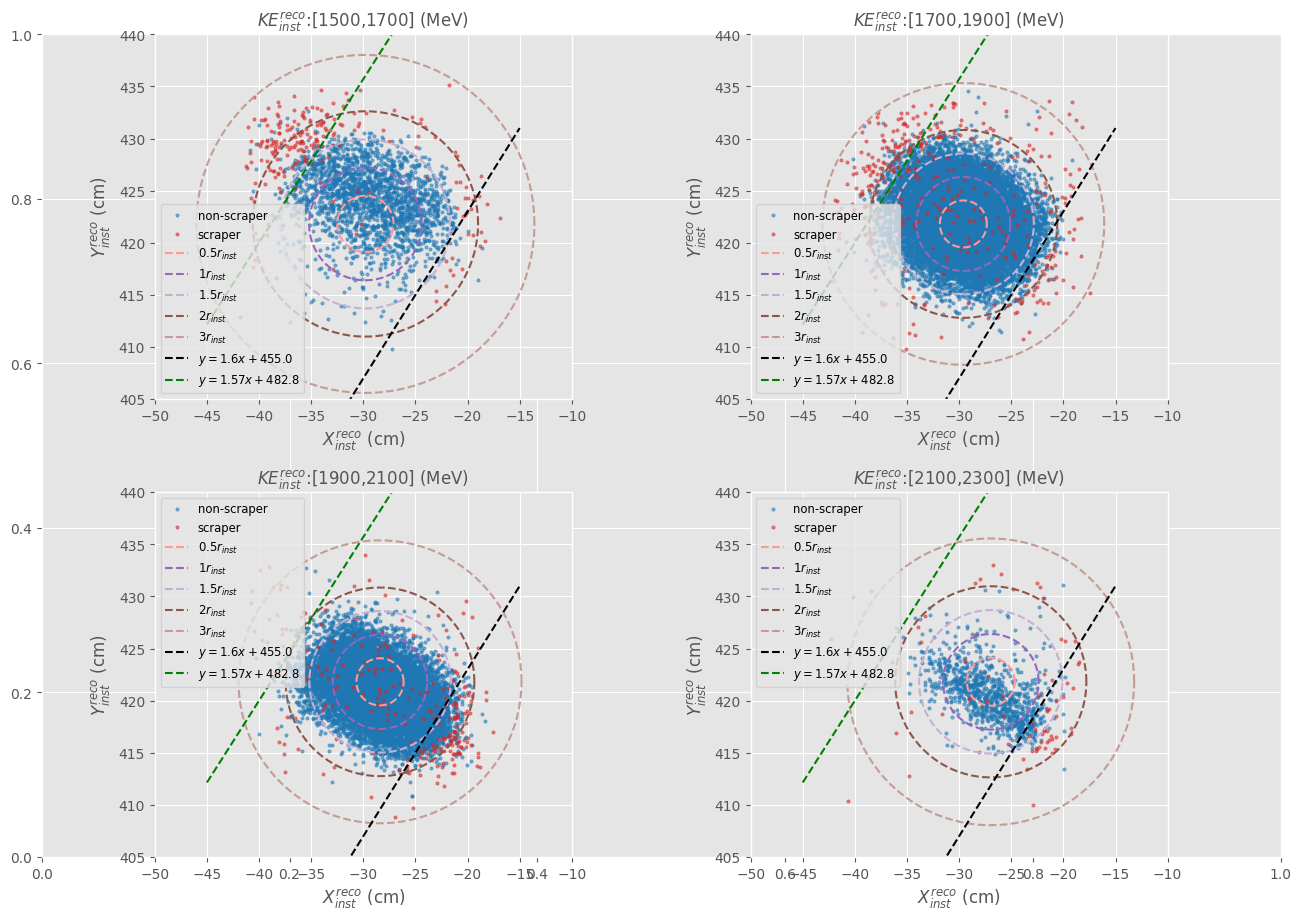

In [30]:
energy_bins = [1500, 1700, 1900, 2100,2300]
residual_range = [-300, 300] # range of residual for plotsdefine 
bins = 50

output_mc = run(filtered_samples,args_pion.selection_masks['mc'])
scraper_thresholds = cex_beam_scraper_fits.GetScraperFits(energy_bins, output_mc["beam_inst_KE"], output_mc["delta_KE_upstream"], bins, residual_range)
position_means = BeamScraperPlots(energy_bins, output_mc, scraper_thresholds)



In [66]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak


def BeamScraperEnergyPlots(beam_inst_KE_bins : list, output_mc : dict[ak.Array], scraper_fits : dict) -> dict:
    """ Scatter plots of events to show beam scraper events as a function of the XY position at the beam instrumentation.

    Args:
        mc (Master.Data): events to look at.
        beam_inst_KE_bins (list): beam kinetic energy bins.
        beam_inst_KE (ak.Array): beam instrumentation kinetic energy.
        delta_KE_upstream (ak.Array): difference in the front facing KE and beam kinetic energy.
        scraper_fits (dict): parameters to define beam scrapers.

    Returns:
        dict: mean and standard deviations of the positions
    """

    results = {}

    scraper_fraction = []
    scraper_fraction_err = []
    bin_centers = []

    n_bins = len(beam_inst_KE_bins) - 1
    scraper_counts = np.zeros(n_bins, dtype=int)
    non_scraper_counts = np.zeros(n_bins, dtype=int)


    for i in range(n_bins):
        e_low = beam_inst_KE_bins[i]
        e_high = beam_inst_KE_bins[i + 1]
        bin_edges = (e_low, e_high)
        if bin_edges not in scraper_fits:
            continue
        # Energy selection
        e = (
            (output_mc["beam_inst_KE"] > e_low)
            & (output_mc["beam_inst_KE"] < e_high)
        )
        if ak.sum(e) == 0:
            continue

        fit_values = scraper_fits[bin_edges]

        is_scraper = (
            output_mc["delta_KE_upstream"][e]
            > (fit_values["mu_e_res"] + 3 * fit_values["sigma_e_res"])
        )
        scraper_counts[i] = int(ak.sum(is_scraper))
        non_scraper_counts[i] = int(ak.sum(~is_scraper))
        n_tot = ak.sum(e)
        n_scraper = ak.sum(is_scraper)

        if n_tot > 0:
            frac = n_scraper / n_tot
            # Binomial uncertainty
            err = np.sqrt(frac * (1 - frac) / n_tot)
        else:
            frac = np.nan
            err = np.nan

        scraper_fraction.append(frac)
        scraper_fraction_err.append(err)
        bin_centers.append(0.5 * (e_low + e_high))

        results[bin_edges] = {
            "n_total": int(n_tot),
            "n_scraper": int(n_scraper),
            "scraper_fraction": frac,
            "scraper_fraction_err": err,
        }

    scraper_area = np.sum(scraper_counts)
    non_scraper_area = np.sum(non_scraper_counts)


    plt.figure()
    plt.step(
        beam_inst_KE_bins,
        np.r_[scraper_fraction, scraper_fraction[-1]],
        where="post",
        linewidth=2,
    )
    plt.ylabel("Scraper fraction")
    plt.title("Scraper fraction vs reconstructed beam energy")
    plt.ylim(0, 0.2)
    
    # plt.bar(
    #     beam_inst_KE_bins[:-1],
    #     scraper_counts*25,
    #     width=np.diff(beam_inst_KE_bins),
    #     align="edge",
    #     color="C3",
    #     label="scraper",
    # )
    # plt.bar(
    #     beam_inst_KE_bins[:-1],
    #     non_scraper_counts,
    #     width=np.diff(beam_inst_KE_bins),
    #     align="edge",
    #     bottom=scraper_counts,
    #     color="C0",
    #     label="non-scraper",
    #     alpha=0.7,
    #)
    #plt.ylabel("Counts")

    plt.xlabel("$KE^{reco}_{inst}$ (MeV)")
    plt.legend()
    plt.grid(True, alpha=0.3)
            
    return results

f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
TrueFiducialCut : len(mc.eventNum)=36347
f=<Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>
PiBeamSelection : len(mc.eventNum)=36347
f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
PandoraTagCut : len(mc.eventNum)=36347
f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
CaloSizeCut : len(mc.eventNum)=36347
f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
HasFinalStatePFOsCut : len(mc.eventNum)=36347
f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
APA3Cut : len(mc.eventNum)=36347
f=<Array [True, False, True, True, ..., True, True, False] type='52654 * ?bool'>
DxyCut : len(mc.eventNum)=36347
f=<Array [True, True, True, True, ..., True, True, False] type='52654 * ?bool'>
CosThetaCut : len(mc.eventNum)=36347


(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(15), np.float64(4.477514429446501), 
np.float64(108.97744107603572))

[[   2.0296008   -28.36120615   12.48193585]
 [ -28.36120615  630.13023163 -327.70622497]
 [  12.48193585 -327.70622497  186.32952538]]


popt=array([  8.1601139 , -36.12520195,  52.43364861])

perr=array([ 1.42464059, 25.10239494, 13.65025734])

(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(66), np.float64(2.9173669337083084), 
np.float64(77.08079119732362))

[[ 2.83258772  0.38331194 -1.01961647]
 [ 0.38331194  1.74387802 -0.93602095]
 [-1.01961647 -0.93602095  1.21852907]]


popt=array([53.18540596, -2.13306266, 31.29636736])

perr=array([1.68302933, 1.32055974, 1.10387004])

(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(164), np.float64(7.013947989784015), 
np.float64(57.771442262973444))

[[ 7.2473202   0.26666268 -1.81222095]
 [ 0.26666268  0.49836437 -0.22150249]
 [-1.81222095 -0.22150249  0.95216374]]


popt=array([143.62210202,   5.09680845,  33.5210406 ])

perr=array([2.69208473, 0.70594927, 0.97578878])

(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(254), np.float64(16.7634684680321), 
np.float64(55.216389463870996))

[[ 1.20508883e+01 -4.69569290e-03 -2.06819384e+00]
 [-4.69569290e-03  3.29903430e-01  4.07213410e-03]
 [-2.06819384e+00  4.07213410e-03  7.18867585e-01]]


popt=array([237.12367396,  16.79194564,  36.89054276])

perr=array([3.47143894, 0.5743722 , 0.84786059])

(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(213), np.float64(24.111869248759376), 
np.float64(57.509698239312506))

[[ 9.59681821  0.15135216 -2.66257478]
 [ 0.15135216  0.59143984 -0.13206824]
 [-2.66257478 -0.13206824  1.48531352]]


popt=array([193.70828366,  23.24255306,  42.03371096])

perr=array([3.09787318, 0.76905126, 1.21873439])

(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(113), np.float64(40.999889942065465), 
np.float64(54.94389763343056))

[[ 4.69230749  0.18175947 -2.02028104]
 [ 0.18175947  0.93177308 -0.267749  ]
 [-2.02028104 -0.267749    1.82601818]]


popt=array([94.04961057, 39.46830837, 38.43937446])

perr=array([2.16617347, 0.96528394, 1.3513024 ])

(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(30), np.float64(67.12238906409402), 
np.float64(110.08522145376736))

[[ 0.9974961   0.33414904 -1.14472586]
 [ 0.33414904  3.27769575 -1.5472031 ]
 [-1.14472586 -1.5472031   3.34497762]]


popt=array([20.23314319, 62.71983158, 32.3045169 ])

perr=array([0.99874727, 1.81044076, 1.828928  ])

(max(y), np.nanmedian(data), np.nanstd(data))=(np.int64(5), np.float64(101.64155985128514), 
np.float64(133.80265902773607))

[[ 1.08862253e-01  2.92666741e+00 -1.04384400e+01]
 [ 2.92666741e+00  1.04165692e+03 -7.21694598e+02]
 [-1.04384400e+01 -7.21694598e+02  2.38394592e+03]]


popt=array([  1.73729731, 110.44283692, 101.09317492])

perr=array([ 0.3299428 , 32.27471025, 48.82566867])

/tmp/ipykernel_366704/959110445.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


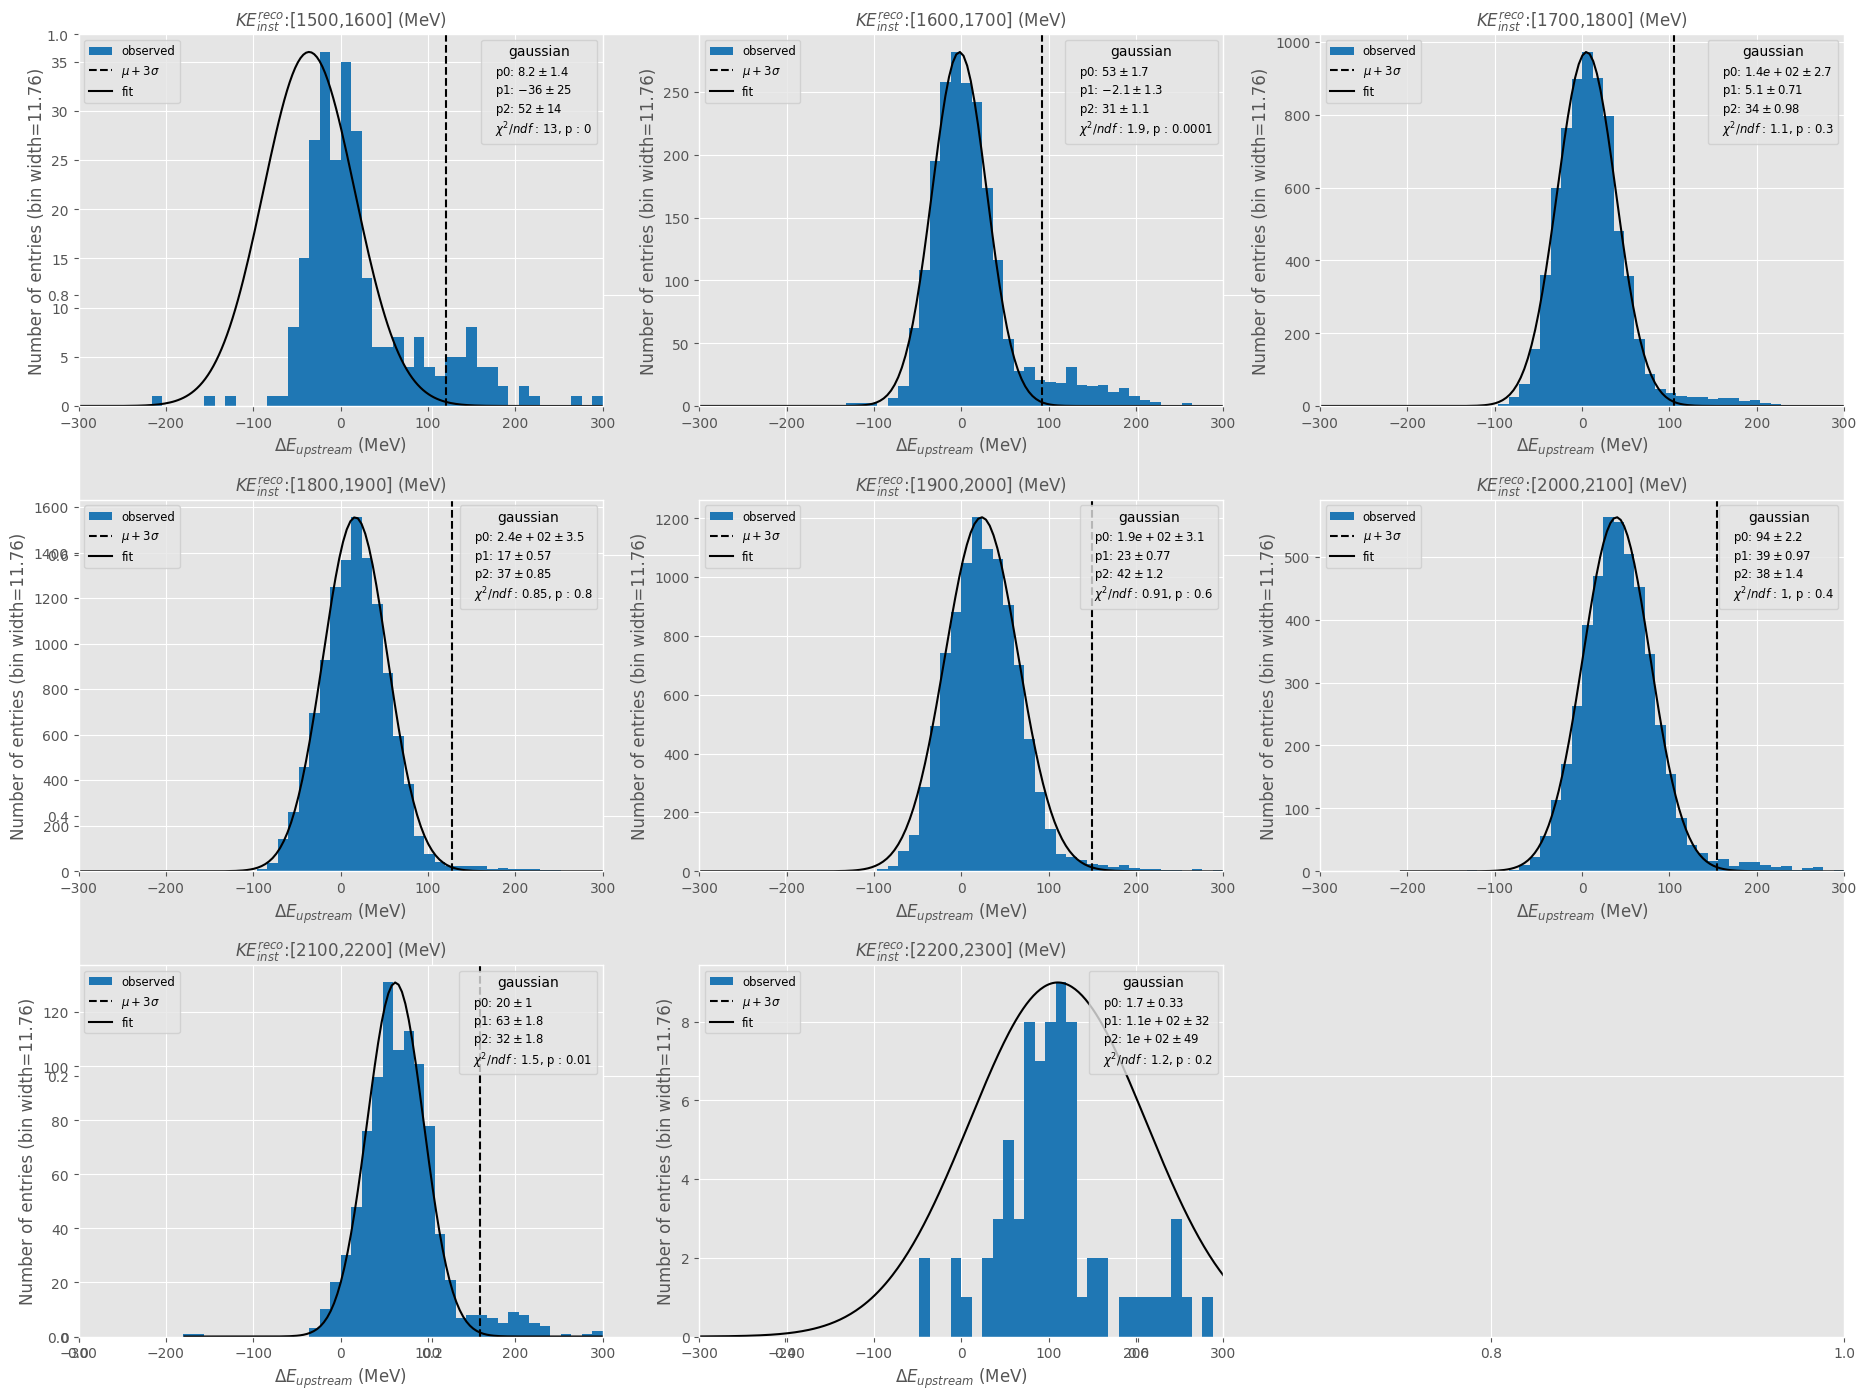

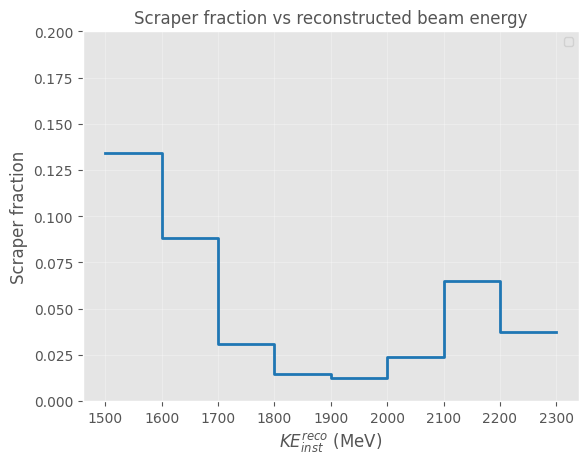

In [68]:
energy_bins = [1500, 1600, 1700, 1800, 1900,  2000,  2100,  2200, 2300]
residual_range = [-300, 300] # range of residual for plotsdefine 
bins = 50

output_mc = run(filtered_samples,args_pion.selection_masks['mc'])
scraper_thresholds = cex_beam_scraper_fits.GetScraperFits(energy_bins, output_mc["beam_inst_KE"], output_mc["delta_KE_upstream"], bins, residual_range)
position_means = BeamScraperEnergyPlots(energy_bins, output_mc, scraper_thresholds)


## Scraper XY

In [10]:
def BeamScraperCutXY(events: Master.Data, a: float = 1.6, b: float = 455.0, operation: str = ">", return_property: bool = False) -> ak.Array:
    x = events.recoParticles.beam_inst_pos.x
    y = events.recoParticles.beam_inst_pos.y

    y_cut = a * x + b

    return SelectionTools.CreateMask(y_cut, operation, y, return_property)

def BeamScraperCutXY_up(events: Master.Data, a: float = 1.57, b: float = 482.8, operation: str = "<", return_property: bool = False) -> ak.Array:
    x = events.recoParticles.beam_inst_pos.x
    y = events.recoParticles.beam_inst_pos.y

    y_cut = a * x + b

    return SelectionTools.CreateMask(y_cut, operation, y, return_property)

In [11]:
mask_mc = BeamScraperCutXY(filtered_samples["mc"])    
args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["BeamScraperCutXY"] = mask_mc

mask_data = BeamScraperCutXY(filtered_samples["data"])    
args_pion.selection_masks["data"]["beam"][file_names["data"]]["BeamScraperCutXY"] = mask_data

In [12]:
mask_mc = BeamScraperCutXY_up(filtered_samples["mc"])    
args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["BeamScraperCutXY_up"] = mask_mc

mask_data = BeamScraperCutXY_up(filtered_samples["data"])    
args_pion.selection_masks["data"]["beam"][file_names["data"]]["BeamScraperCutXY_up"] = mask_data

In [13]:
masks = {k : SelectionTools.CombineMasks(args_pion.selection_masks[k]["beam"][file_names[k]]) for k in filtered_samples}
{k : v.Filter([masks[k]], [masks[k]], returnCopy = True) for k, v in filtered_samples.items()}
beam_filtered_samples = {k : v.Filter([masks[k]], [masks[k]], returnCopy = True) for k, v in filtered_samples.items()}

f=<Array [False, False, True, True, ..., False, True, False] type='52654 * ?bool'>
f=<Array [False, False, False, ..., False, False, False] type='263960 * ?bool'>
f=<Array [False, False, True, True, ..., False, True, False] type='52654 * ?bool'>
f=<Array [False, False, False, ..., False, False, False] type='263960 * ?bool'>


In [14]:
args_pion.selection_masks["mc"]["beam"][file_names["mc"]]

{'TrueFiducialCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'PiBeamSelection': <Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>,
 'PandoraTagCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'CaloSizeCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'HasFinalStatePFOsCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'APA3Cut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'DxyCut': <Array [True, False, True, True, ..., True, True, False] type='52654 * ?bool'>,
 'CosThetaCut': <Array [True, True, True, True, ..., True, True, False] type='52654 * ?bool'>,
 'BeamScraperCut': <Array [True, True, True, True, ..., True, True, False] type='52654 * bool'>,
 'BeamScraperCutXY': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'BeamScraperCutXY_up': <Array [True, True, 

no samples rejected for selection TrueFiducialCut
f=<Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>
f=<Array [True, True, True, True, ..., True, True, True] type='263960 * bool'>
f=<Array [True, False, False, False, ..., True, False, False] type='52654 * bool'>
f=<Array [True, True, False, False, ..., True, True, True] type='263960 * bool'>
f=<Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>
f=<Array [False, False, True, ..., False, False, False] type='263960 * bool'>


no samples rejected for selection PandoraTagCut
f=<Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>
f=<Array [False, False, True, ..., False, False, False] type='263960 * bool'>
no samples rejected for selection CaloSizeCut
f=<Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>
f=<Array [False, False, True, ..., False, False, False] type='263960 * bool'>
f=<Array [False, False, False, ..., False, False, False] type='52654 * bool'>
f=<Array [False, False, True, ..., False, False, False] type='263960 * bool'>
f=<Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>
f=<Array [False, False, False, ..., False, False, False] type='263960 * bool'>
no samples rejected for selection APA3Cut
f=<Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>
f=<Array [False, False, False, ..., False, False, False] type='263960 * bool'>
f=<Array [False, True, False, ..., False, False, True] type='52654 * ?bool

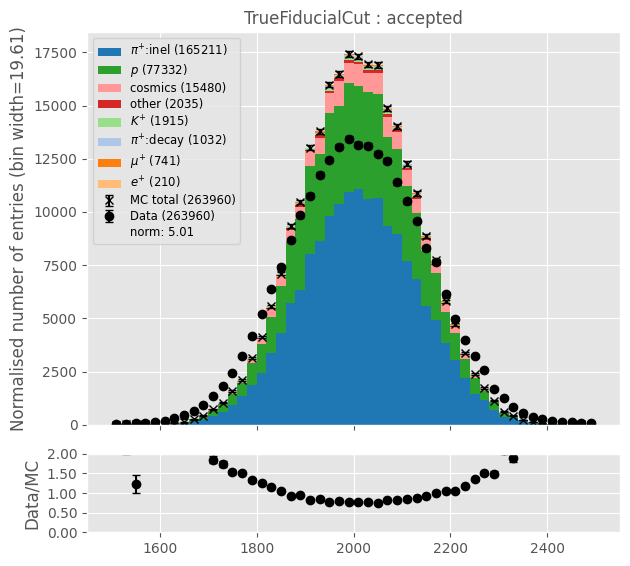

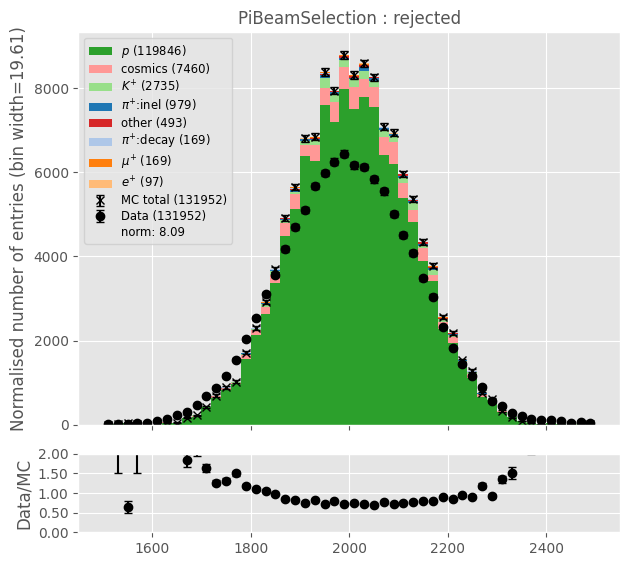

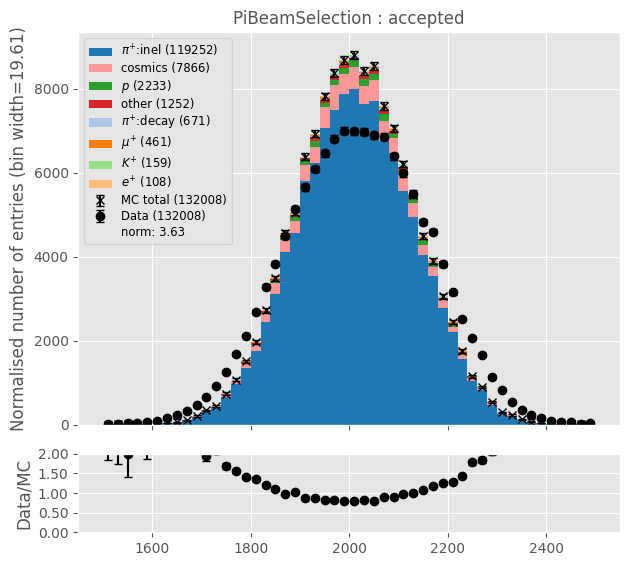

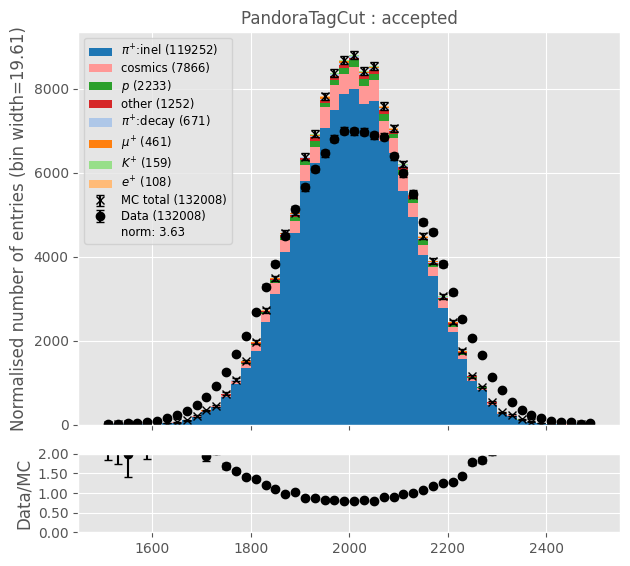

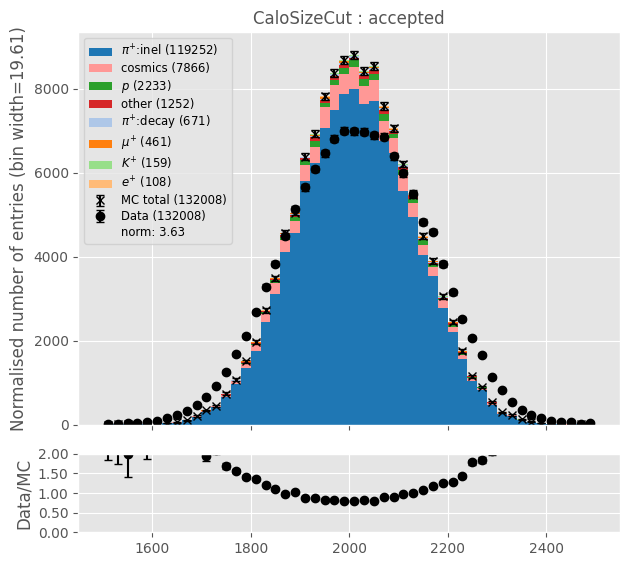

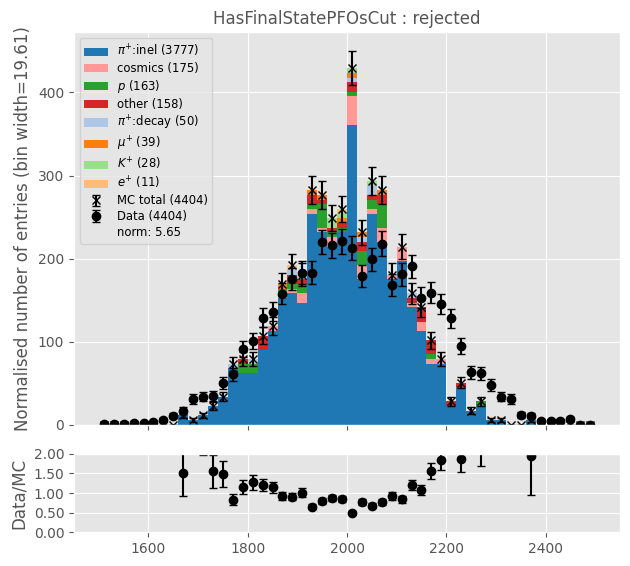

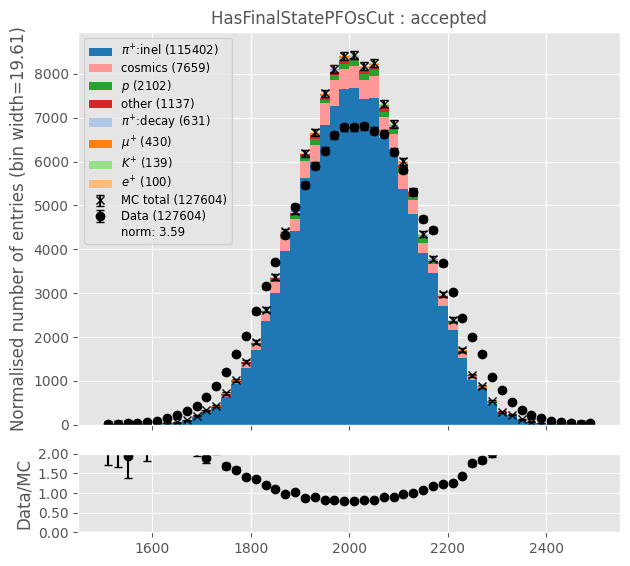

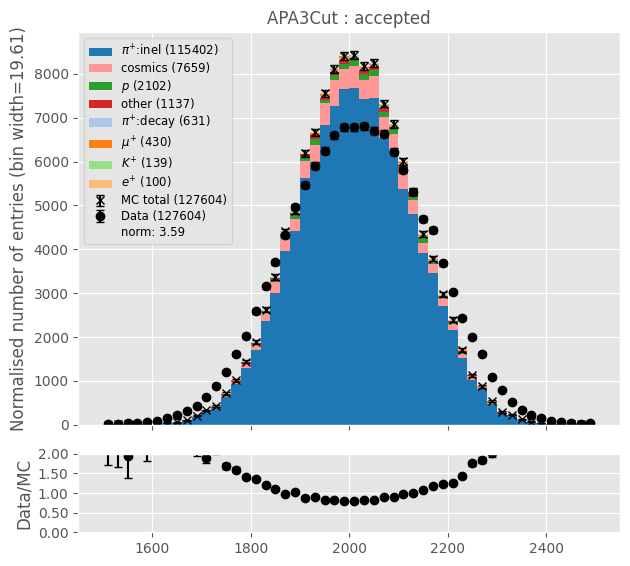

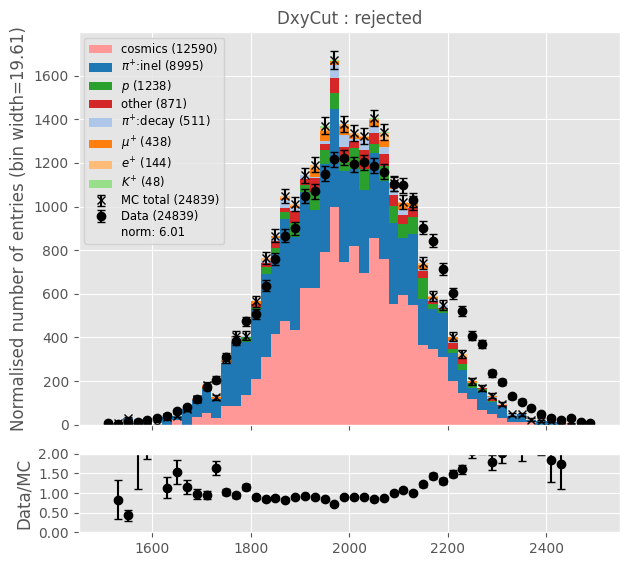

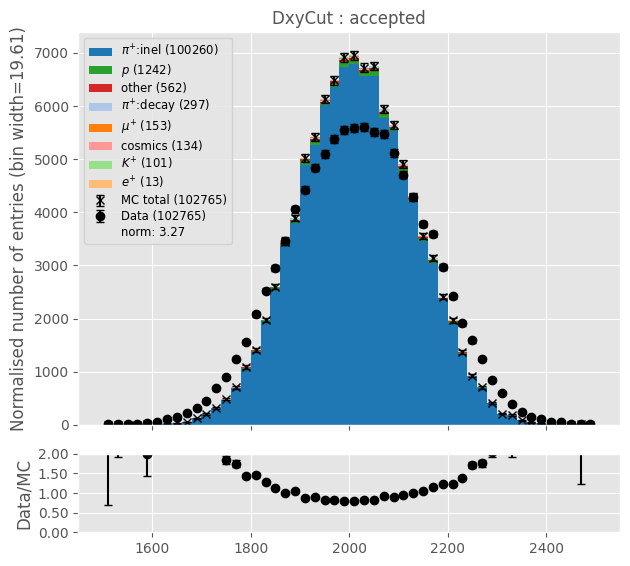

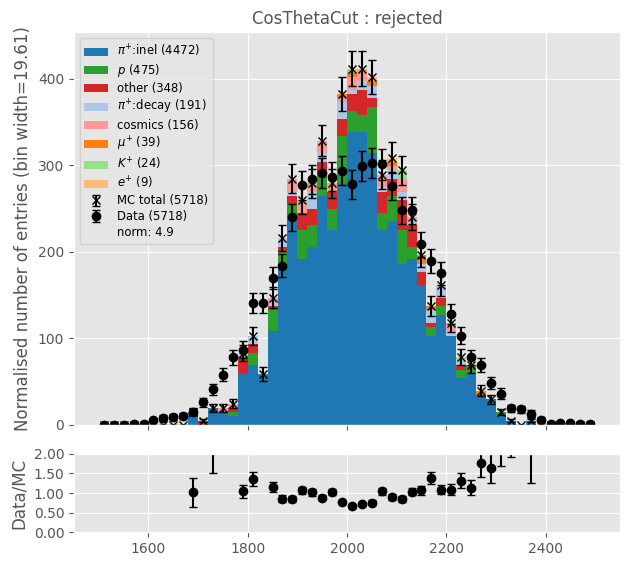

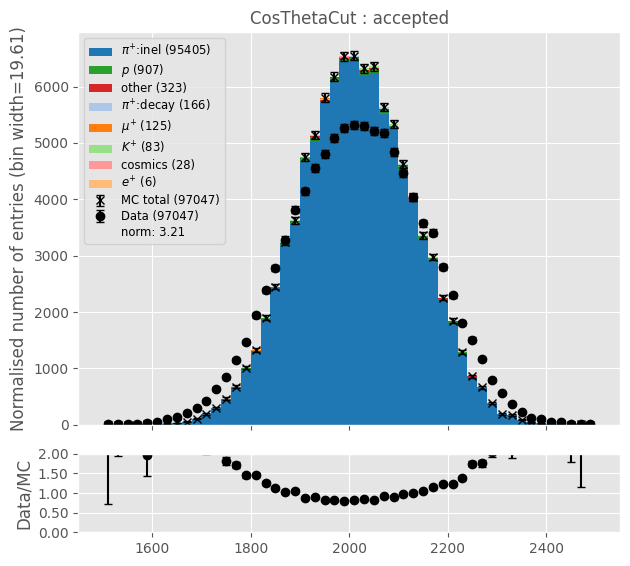

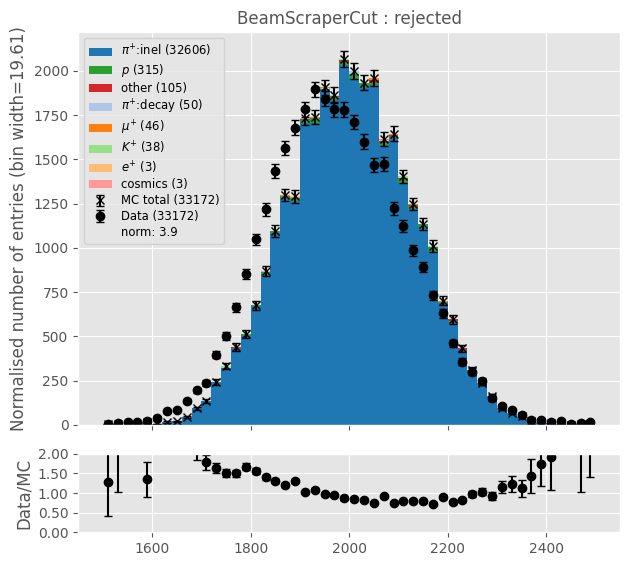

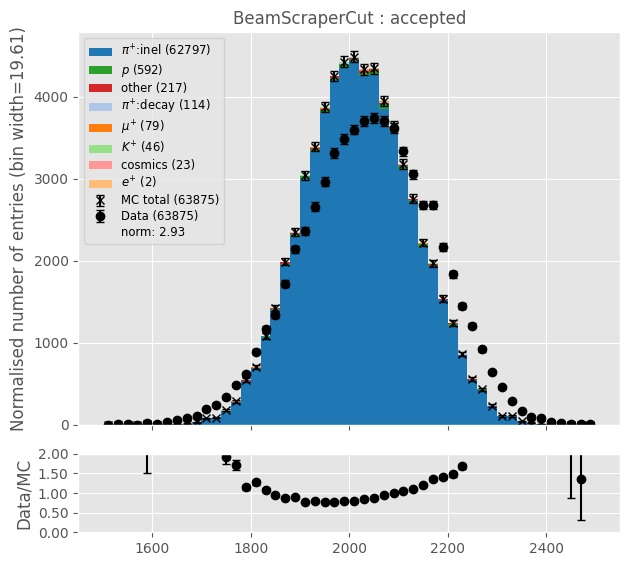

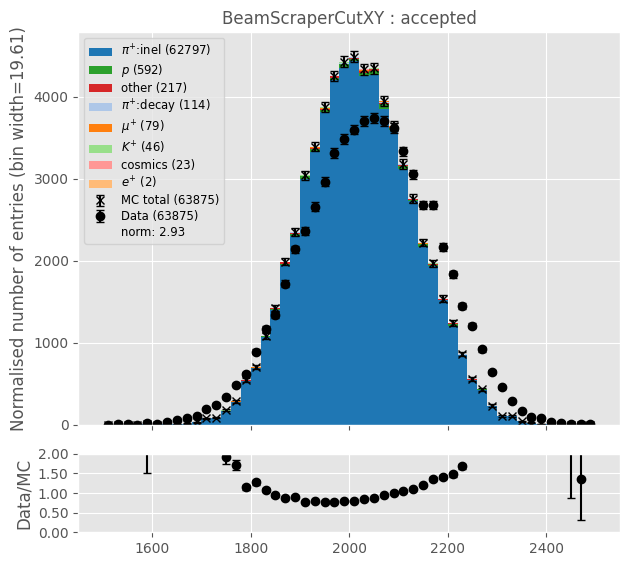

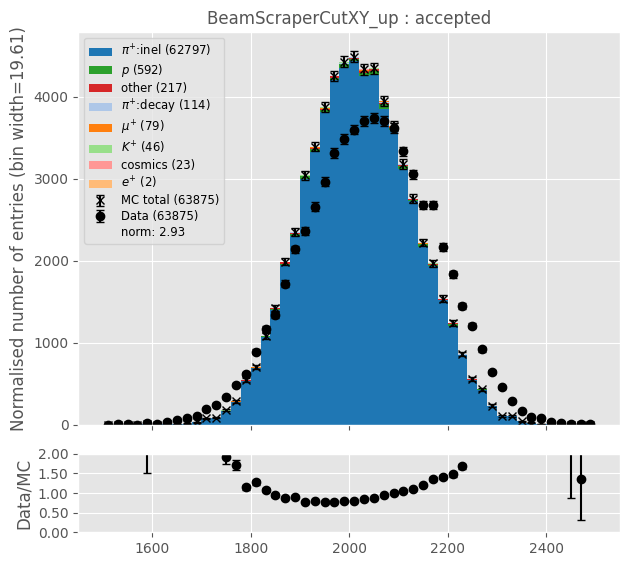

In [15]:
# accept reject for beam cuts
plot_accept_reject("beam", filtered_samples)

In [16]:
args_pion.selection_masks["mc"]["beam"][file_names["mc"]]

{'TrueFiducialCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'PiBeamSelection': <Array [False, True, True, True, ..., False, True, True] type='52654 * bool'>,
 'PandoraTagCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'CaloSizeCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'HasFinalStatePFOsCut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'APA3Cut': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'DxyCut': <Array [True, False, True, True, ..., True, True, False] type='52654 * ?bool'>,
 'CosThetaCut': <Array [True, True, True, True, ..., True, True, False] type='52654 * ?bool'>,
 'BeamScraperCut': <Array [True, True, True, True, ..., True, True, False] type='52654 * bool'>,
 'BeamScraperCutXY': <Array [True, True, True, True, ..., True, True, True] type='52654 * bool'>,
 'BeamScraperCutXY_up': <Array [True, True, 

In [17]:

sideband_mc = (
          args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["PiBeamSelection"]
        & args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["TrueFiducialCut"]
        & args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["PandoraTagCut"]
        & args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["CaloSizeCut"]
        & args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["DxyCut"]
        & args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["CosThetaCut"]
        & args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["APA3Cut"]
        & ~args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["BeamScraperCut"]
        & args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["HasFinalStatePFOsCut"]
        & args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["BeamScraperCutXY"]
        & args_pion.selection_masks["mc"]["beam"][file_names["mc"]]["BeamScraperCutXY_up"])

 
sideband_data = (
        args_pion.selection_masks["data"]["beam"][file_names["data"]]["PiBeamSelection"]
        & args_pion.selection_masks["data"]["beam"][file_names["data"]]["TrueFiducialCut"]
        & args_pion.selection_masks["data"]["beam"][file_names["data"]]["PandoraTagCut"]
        & args_pion.selection_masks["data"]["beam"][file_names["data"]]["CaloSizeCut"]
        & args_pion.selection_masks["data"]["beam"][file_names["data"]]["DxyCut"]
        & args_pion.selection_masks["data"]["beam"][file_names["data"]]["CosThetaCut"]
        & args_pion.selection_masks["data"]["beam"][file_names["data"]]["APA3Cut"]
        & ~args_pion.selection_masks["data"]["beam"][file_names["data"]]["BeamScraperCut"]
        & args_pion.selection_masks["data"]["beam"][file_names["data"]]["HasFinalStatePFOsCut"]
        & args_pion.selection_masks["data"]["beam"][file_names["data"]]["BeamScraperCutXY"]
        & args_pion.selection_masks["data"]["beam"][file_names["data"]]["BeamScraperCutXY_up"])

sideband_selection = {"mc" : sideband_mc, "data" : sideband_data}
sideband_sample = {k : v.Filter([sideband_selection[k]], [sideband_selection[k]], returnCopy = True) for k, v in filtered_samples.items()}

f=<Array [False, False, False, ..., False, False, False] type='52654 * ?bool'>
f=<Array [False, False, False, ..., False, False, False] type='263960 * ?bool'>


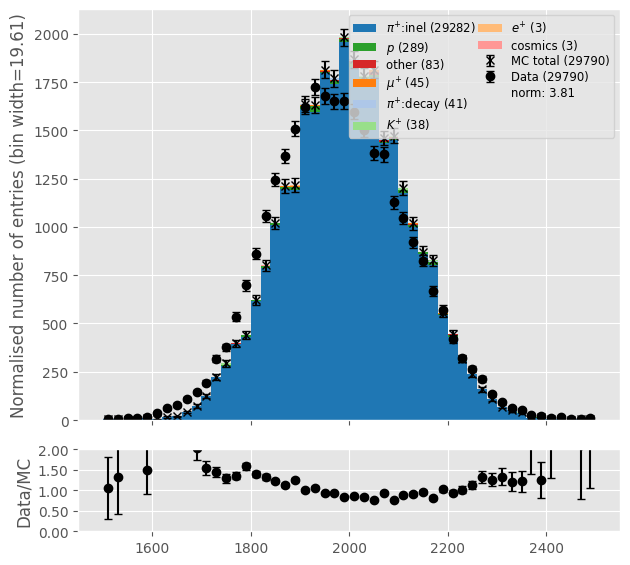

In [18]:
Plots.PlotTagged(
    sideband_sample['mc'].recoParticles.beam_inst_P,
    cross_section.Tags.GenerateTrueBeamParticleTags(sideband_sample['mc']),
    data2=sideband_sample['data'].recoParticles.beam_inst_P,
    x_range=[1500,2500],
    norm=True,
    bins=50,
)


# ratio reweight

In [48]:
def MirrorReWeight(p_MC, p_Data, p_nominal : float, bins : int = 10, p_range : np.array = np.array([0.75, 1.25]), book : Plots.PlotBook = Plots.PlotBook.null):
    p_mc1, edges = np.histogram(np.array(p_MC), bins, range = p_nominal * p_range)
    p_data1 = np.histogram(np.array(p_Data), bins, range = p_nominal * p_range)[0]

    p_mc = np.flip(p_mc1)
    p_data = np.flip(p_data1)

    with Plots.RatioPlot((edges[1:] + edges[:-1]) / 2, p_data, p_mc, np.sqrt(p_data), np.sqrt(p_mc), "$P_{inst}^{reco}$ (MeV)", "Data/MC") as ratio_plot:
        Plots.Plot(ratio_plot.x, ratio_plot.y1, yerr = ratio_plot.y1_err, newFigure = False)
        Plots.Plot(ratio_plot.x, ratio_plot.y2, yerr = ratio_plot.y2_err, newFigure = False, ylabel = "Counts")
    book.Save()

    scale = sum(ratio_plot.y1) / sum(ratio_plot.y2)

    ratio = scale * np.nan_to_num(cross_section.nandiv(ratio_plot.y2, ratio_plot.y1), posinf = 0)
    ratio_err = np.nan_to_num(abs(ratio * np.sqrt(cross_section.nandiv(ratio_plot.y1_err, ratio_plot.y1)**2 + cross_section.nandiv(ratio_plot.y2_err, ratio_plot.y2)**2)))

    Plots.Plot(ratio_plot.x, ratio, yerr = ratio_err, xlabel = "$P_{inst}^{reco}$ (MeV)", ylabel = "$r$")
    book.Save()

    results = {}
    for f in [cross_section.Fitting.gaussian]:
        Plots.plt.figure()
        results[f.__name__] = cross_section.Fitting.Fit(ratio_plot.x[ratio > 0], ratio[ratio > 0], ratio_err[ratio > 0], f, plot = True, xlabel = "$P_{inst}^{reco}$(MeV)", ylabel = "$r$")
        book.Save()
    return results

pdf 2GeV_reweight.pdf has been opened
[[ 3.74671020e-04 -1.95583043e-02 -9.46210602e-02]
 [-1.95583043e-02  7.64393388e+01 -5.55275938e+01]
 [-9.46210602e-02 -5.55275938e+01  1.22397592e+02]]
[[ 2.75059953e+01  3.22974918e+00 -5.31030701e+00  2.20305202e+02]
 [ 3.22974918e+00  6.52493296e+01 -1.29386062e+00 -6.04319326e+00]
 [-5.31030701e+00 -1.29386062e+00  1.04359703e+00 -4.13872955e+01]
 [ 2.20305202e+02 -6.04319326e+00 -4.13872955e+01  1.86351655e+03]]
[[ 2.03272600e+00 -2.01417815e-03  4.95936841e-07]
 [-2.01417815e-03  2.00244499e-06 -4.94603320e-10]
 [ 4.95936841e-07 -4.94603320e-10  1.22538064e-13]]
[[ 1.41788010e+05 -8.92886373e+02  1.20540339e+03  1.05465588e+04
  -6.07862823e+05]
 [-8.92886373e+02  8.39727702e+01 -6.58022289e+01 -7.06163627e+01
   3.84137178e+03]
 [ 1.20540339e+03 -6.58022289e+01  1.36372158e+02  9.54595617e+01
  -5.18766801e+03]
 [ 1.05465588e+04 -7.06163627e+01  9.54595617e+01  7.96283630e+02
  -4.52528313e+04]
 [-6.07862823e+05  3.84137178e+03 -5.18766801

/home/suw//pi0-analysis/analysis/python/analysis/Fitting.py:179: RuntimeWarning: overflow encountered in scalar power
  A = (n_alpha)**p4 * np.exp(-a_alpha**2 / 2)
/home/suw//pi0-analysis/analysis/python/analysis/Fitting.py:189: RuntimeWarning: invalid value encountered in multiply
  y = np.where(t > -p3, np.exp(-t**2 / 2), A * Utils.fpower(B - t, -p4))
/home/suw//pi0-analysis/analysis/python/analysis/Fitting.py:179: RuntimeWarning: invalid value encountered in scalar power
  A = (n_alpha)**p4 * np.exp(-a_alpha**2 / 2)
/home/suw//pi0-analysis/analysis/python/analysis/Utils.py:22: RuntimeWarning: overflow encountered in power
  y = num.astype("complex")**exp


[[ 3.77770066e-04 -1.89215549e-02 -9.71284147e-02  2.16844405e-17
  -5.77399608e-20  1.95583278e-04 -5.39099830e-12]
 [-1.89215549e-02  7.58134436e+01 -5.54093657e+01  3.01922323e-14
   1.70284229e-17 -9.79627572e-03  2.70044275e-10]
 [-9.71284147e-02 -5.54093657e+01  1.24083543e+02 -4.40803594e-14
  -1.33103222e-18 -5.02863922e-02  1.38608495e-09]
 [ 2.16844405e-17  3.01922323e-14 -4.40803594e-14  1.79856975e-29
   2.41985931e-30 -7.20658141e-15  7.21813934e-16]
 [-5.77399608e-20  1.70284229e-17 -1.33103222e-18  2.41985931e-30
   3.55683893e-29 -1.06260476e-13  1.06265322e-14]
 [ 1.95583278e-04 -9.79627572e-03 -5.02863922e-02 -7.20658141e-15
  -1.06260476e-13  3.17452948e+02 -3.17466629e+01]
 [-5.39099830e-12  2.70044275e-10  1.38608495e-09  7.21813934e-16
   1.06265322e-14 -3.17466629e+01  3.17559620e+00]]


/home/suw//pi0-analysis/analysis/python/analysis/Fitting.py:295: RuntimeWarning: invalid value encountered in scalar power
  A = (n/abs(alpha))**n * np.exp(-0.5 * abs(alpha)**2)


[[ 2.06344592e-03  7.58078383e-02 -6.89381815e-01 -1.66675127e-03
   9.70532534e-02 -7.49667525e-01]
 [ 7.58078383e-02  1.32856417e+02 -1.29683243e+02 -1.06368465e-01
  -5.71260010e+01 -4.10019890e+01]
 [-6.89381815e-01 -1.29683243e+02  3.93272537e+02  6.10056354e-01
   4.20172226e+00  2.36343316e+02]
 [-1.66675127e-03 -1.06368465e-01  6.10056354e-01  2.79363611e-03
  -6.02885313e-02  2.70423562e-01]
 [ 9.70532534e-02 -5.71260010e+01  4.20172226e+00 -6.02885313e-02
   2.71488216e+02 -6.40694361e+01]
 [-7.49667525e-01 -4.10019890e+01  2.36343316e+02  2.70423562e-01
  -6.40694361e+01  5.16775499e+02]]


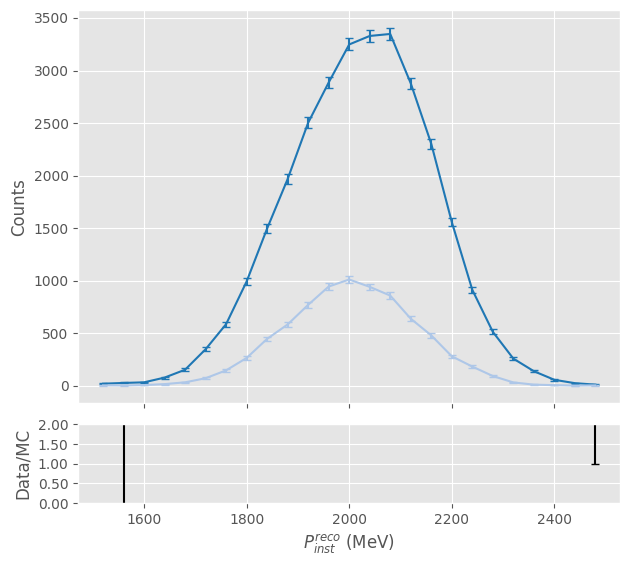

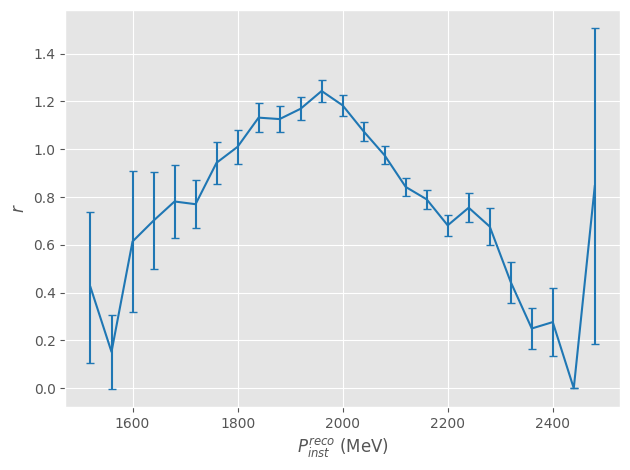

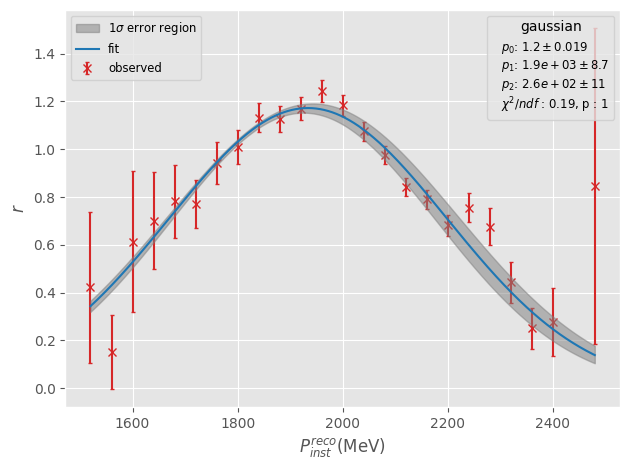

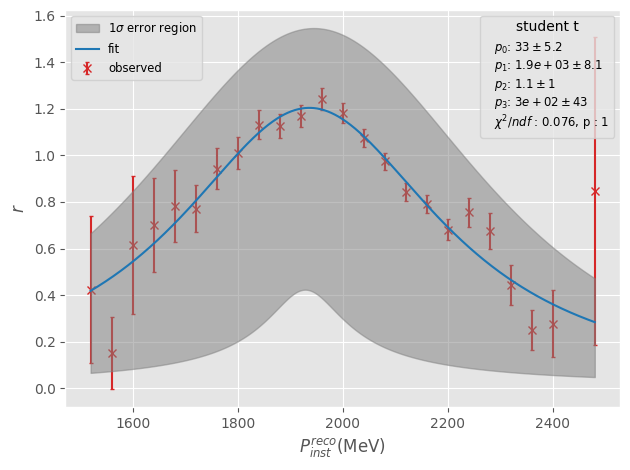

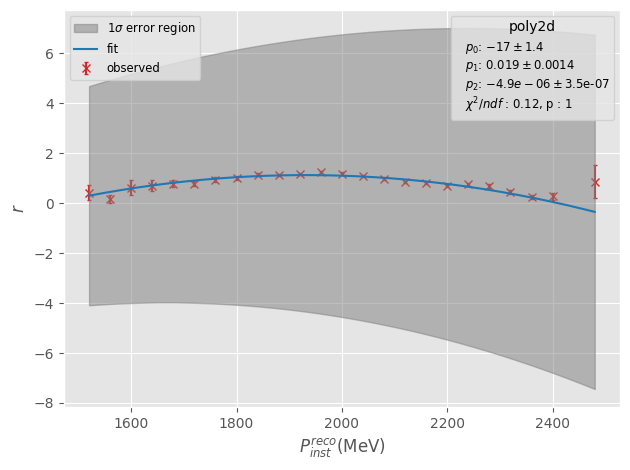

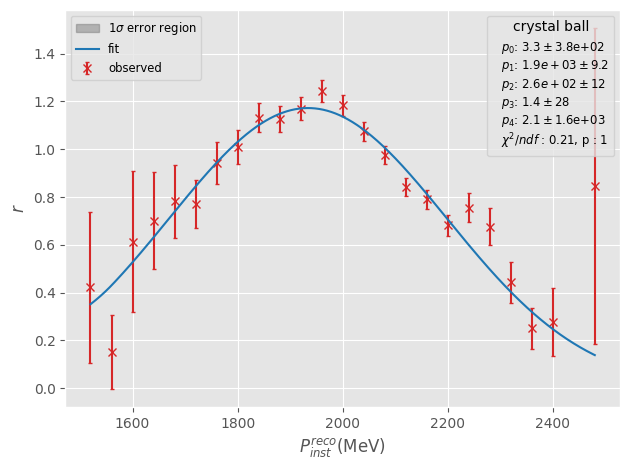

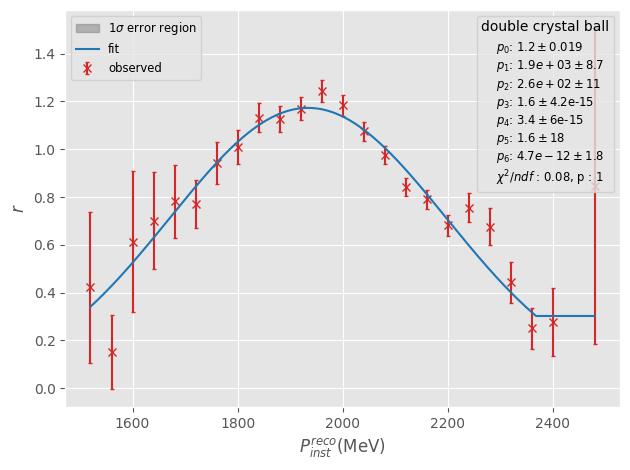

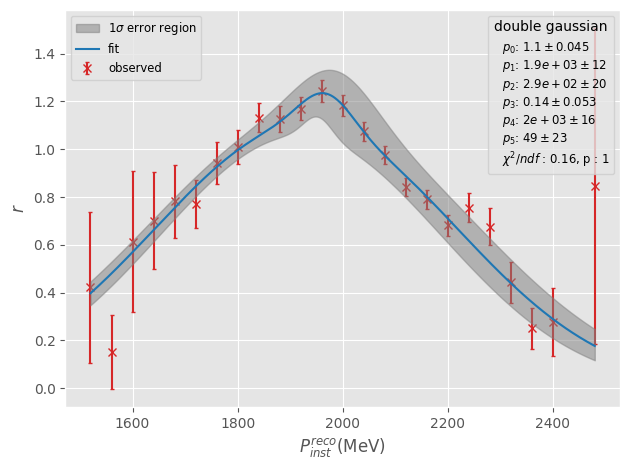

In [47]:
book = Plots.PlotBook("2GeV_reweight.pdf", True)
mirror_results = MirrorReWeight(sideband_sample["mc"].recoParticles.beam_inst_P, sideband_sample["data"].recoParticles.beam_inst_P, args_pion.beam_momentum, 25, np.array([0.75, 1.25]),book=book)

pdf 2GeV_reweight.pdf has been opened
[[ 3.74671039e-04  1.95583422e-02 -9.46210345e-02]
 [ 1.95583422e-02  7.64393393e+01  5.55275856e+01]
 [-9.46210345e-02  5.55275856e+01  1.22397579e+02]]
[[ 2.75097341e+01 -3.23011001e+00 -5.31030685e+00  2.20335534e+02]
 [-3.23011001e+00  6.52487987e+01  1.29375722e+00  6.04022485e+00]
 [-5.31030685e+00  1.29375722e+00  1.04345317e+00 -4.13874921e+01]
 [ 2.20335534e+02  6.04022485e+00 -4.13874921e+01  1.86376521e+03]]
[[ 1.88891901e+00 -1.90700939e-03  4.78132586e-07]
 [-1.90700939e-03  1.93122797e-06 -4.85701192e-10]
 [ 4.78132586e-07 -4.85701192e-10  1.22538064e-13]]
[[ 8.41908145e+00 -1.77108667e+00  7.76846587e+00  1.26463943e+00
  -6.45439816e+01]
 [-1.77108667e+00  6.68992917e+01  4.56069412e+01 -2.62934012e-01
   1.38761116e+01]
 [ 7.76846587e+00  4.56069412e+01  1.74674399e+02  2.70177116e+00
  -7.60049568e+01]
 [ 1.26463943e+00 -2.62934012e-01  2.70177116e+00  2.43616983e-01
  -1.01949610e+01]
 [-6.45439816e+01  1.38761116e+01 -7.60049568

/home/suw//pi0-analysis/analysis/python/analysis/Fitting.py:179: RuntimeWarning: invalid value encountered in scalar power
  A = (n_alpha)**p4 * np.exp(-a_alpha**2 / 2)


[[ 3.77770363e-04  1.89215387e-02 -9.71281610e-02  1.95593113e-04
   8.40933609e-11  0.00000000e+00  0.00000000e+00]
 [ 1.89215387e-02  7.58131444e+01  5.54091027e+01  9.79689213e-03
  -9.47451226e-09  0.00000000e+00  0.00000000e+00]
 [-9.71281610e-02  5.54091027e+01  1.24082845e+02 -5.02881263e-02
  -8.43615947e-08  0.00000000e+00  0.00000000e+00]
 [ 1.95593113e-04  9.79689213e-03 -5.02881263e-02  2.43325148e+02
  -2.78009554e+01  0.00000000e+00  0.00000000e+00]
 [ 8.40933609e-11 -9.47451226e-09 -8.43615947e-08 -2.78009554e+01
   3.17741504e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]


/home/suw//pi0-analysis/analysis/python/analysis/Fitting.py:295: RuntimeWarning: invalid value encountered in scalar power
  A = (n/abs(alpha))**n * np.exp(-0.5 * abs(alpha)**2)


[[ 2.79363614e-03  6.02889675e-02  2.70423506e-01 -1.66675118e-03
   1.06368346e-01  6.10056268e-01]
 [ 6.02889675e-02  2.71488215e+02  6.40692814e+01 -9.70532775e-02
  -5.71260010e+01 -4.20171385e+00]
 [ 2.70423506e-01  6.40692814e+01  5.16775571e+02 -7.49667595e-01
   4.10020088e+01  2.36343351e+02]
 [-1.66675118e-03 -9.70532775e-02 -7.49667595e-01  2.06344597e-03
  -7.58077589e-02 -6.89381779e-01]
 [ 1.06368346e-01 -5.71260010e+01  4.10020088e+01 -7.58077589e-02
   1.32856414e+02  1.29683220e+02]
 [ 6.10056268e-01 -4.20171385e+00  2.36343351e+02 -6.89381779e-01
   1.29683220e+02  3.93272513e+02]]


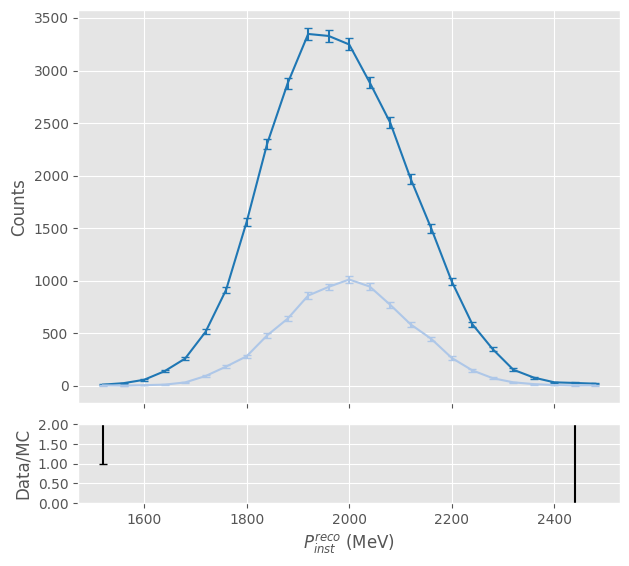

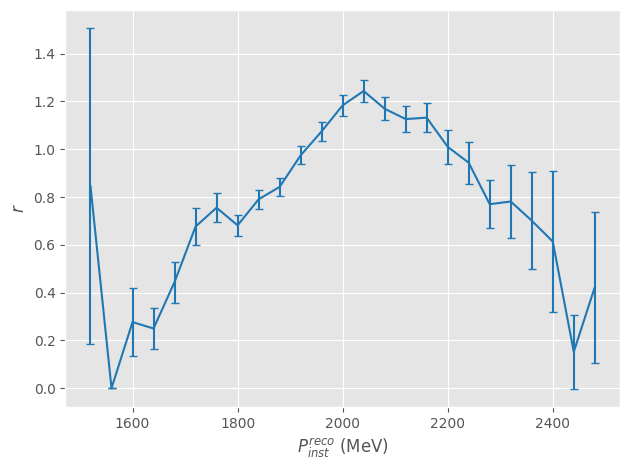

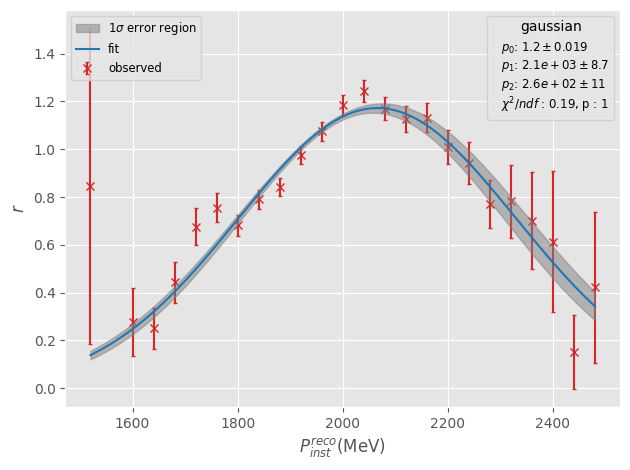

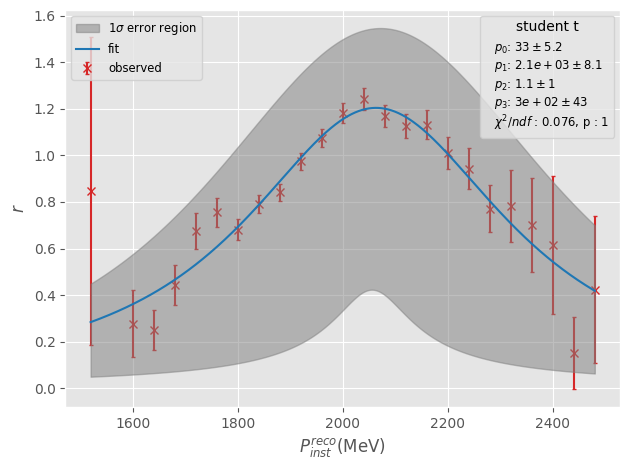

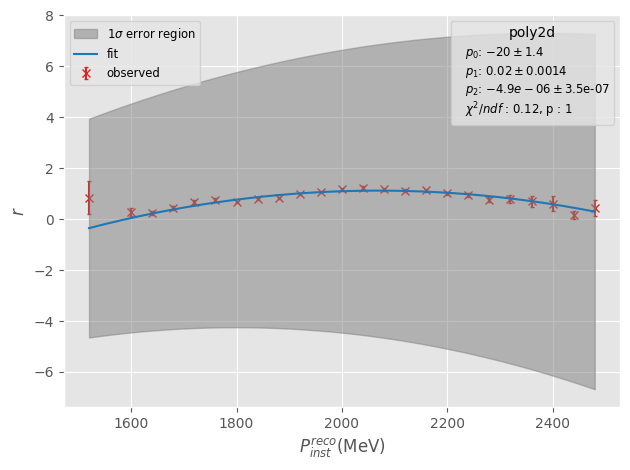

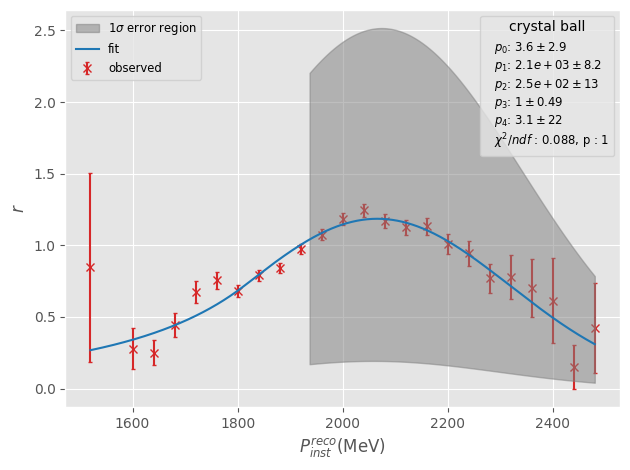

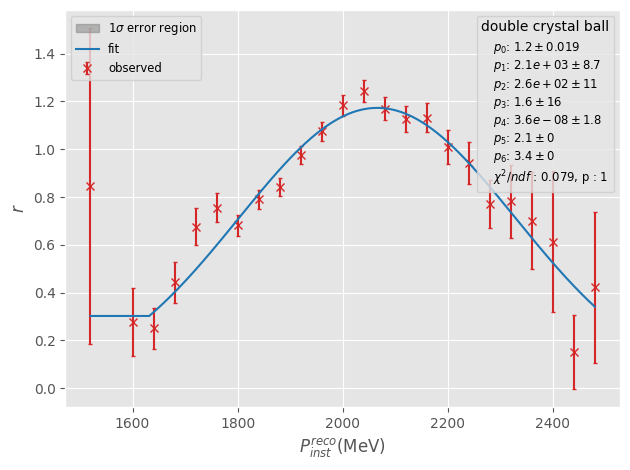

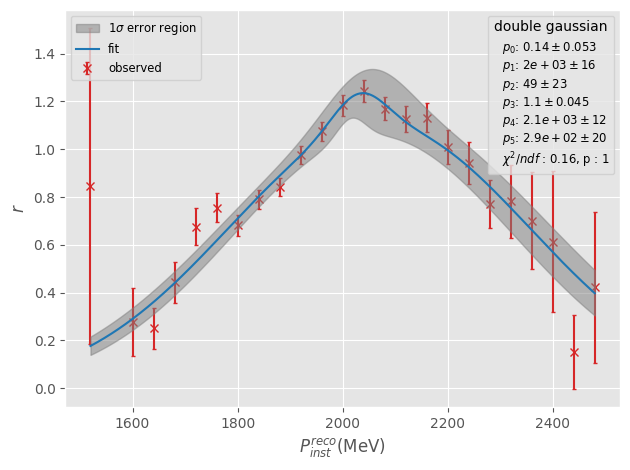

In [44]:
book = Plots.PlotBook("2GeV_reweight.pdf", True)
results = cex_beam_reweight.ReWeight(sideband_sample["mc"].recoParticles.beam_inst_P, sideband_sample["data"].recoParticles.beam_inst_P, args_pion.beam_momentum, 25, np.array([0.75, 1.25]),book=book)

In [45]:
results["gaussian"]

(array([1.17231846e+00, 2.06594211e+03, 2.64248686e+02]),
 array([ 0.01935642,  8.74295941, 11.06334394]))

In [64]:
def ReWeightResults(sideband_mc : dict, sideband_data : dict, args : cross_section.argparse.Namespace, bins : int, reweight_results : dict, reweight_func : str, book : Plots.PlotBook = Plots.PlotBook.null, norm : float = 3.81):
    """Apply reweighting to samples.
    
    Args:
        sideband_mc: MC sample (Master.Data object)
        sideband_data: Data sample (Master.Data object)
        args: analysis arguments
        bins: number of bins for plots
        reweight_results: reweighting fit results
        reweight_func: function name used for reweighting
        book: plot book for saving plots
        norm: normalization factor
    """
    weights = cross_section.RatioWeights(np.array(sideband_mc.recoParticles.beam_inst_P), reweight_func, reweight_results[reweight_func][0], 3)
 

    plot_range = [args.beam_momentum * 0.75, args.beam_momentum * 1.25]

    Plots.PlotHist(weights, range = [0, 3], xlabel = "weights", truncate = True)
    book.Save()
    
    Plots.PlotTagged(sideband_mc.recoParticles.beam_inst_P, cross_section.Tags.GenerateTrueBeamParticleTags(sideband_mc), data2 = sideband_data.recoParticles.beam_inst_P, x_range = plot_range, norm = norm, data_weights = None, bins = bins, x_label = "$P_{inst}^{reco}$ (MeV)", ncols = 1)
    Plots.plt.title("nominal", pad = 15)
    book.Save()

    Plots.PlotTagged(sideband_mc.recoParticles.beam_inst_P, cross_section.Tags.GenerateTrueBeamParticleTags(sideband_mc), data2 = sideband_data.recoParticles.beam_inst_P, x_range = plot_range, norm = norm, data_weights = weights, bins = bins, x_label = "$P_{inst}^{reco}$ (MeV)", ncols = 1)
    Plots.plt.title(f"reweighted : {reweight_func}", pad = 15)
    book.Save()
    return weights

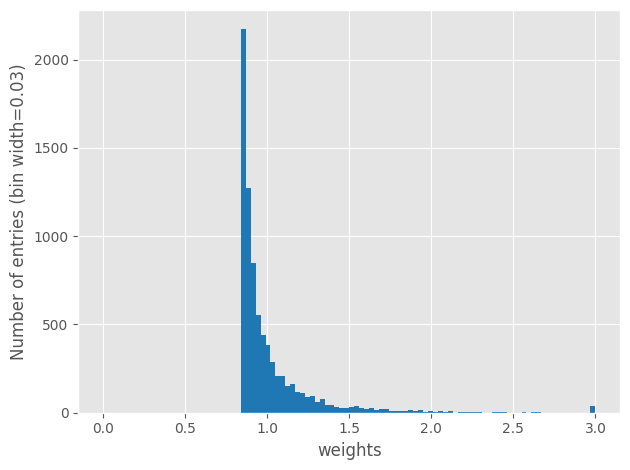

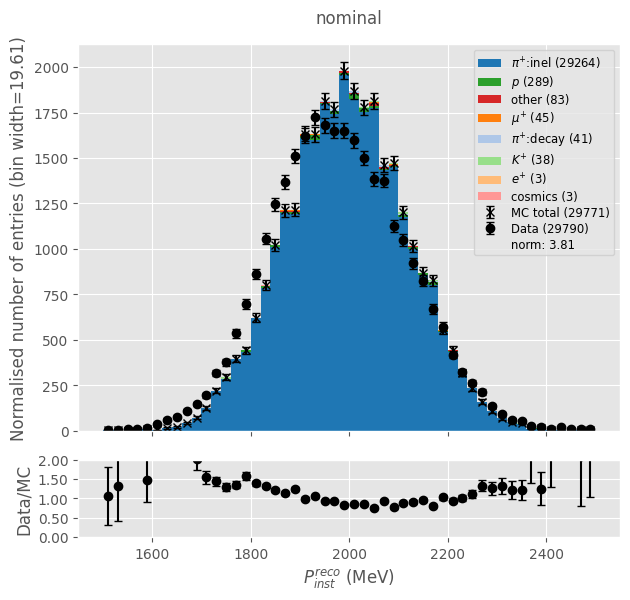

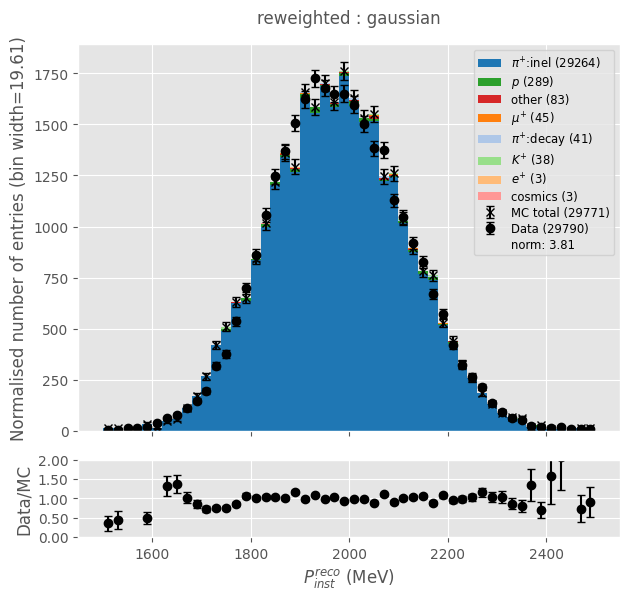

In [65]:
# Apply normal weights to sideband sample
sideband_weights = ReWeightResults(sideband_sample["mc"],sideband_sample["data"],args_pion, 50, results, 'gaussian', book = book, norm = 3.81)
#smearing_results = cex_beam_reweight.Smearing(sideband_sample["mc"].recoParticles.beam_inst_P, sideband_sample["data"].recoParticles.beam_inst_P, 10, [1650, 2350], book, sideband_weights)

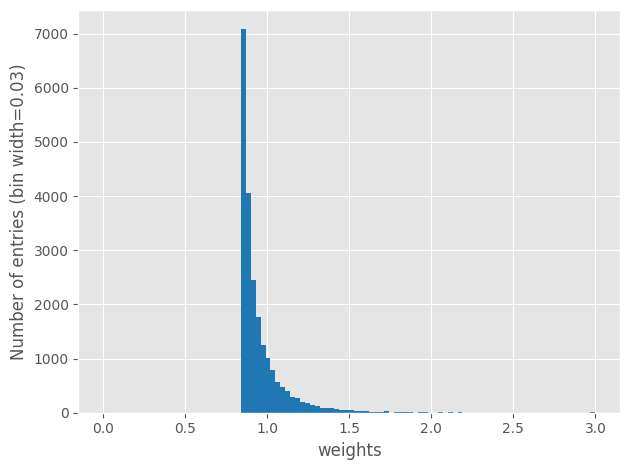

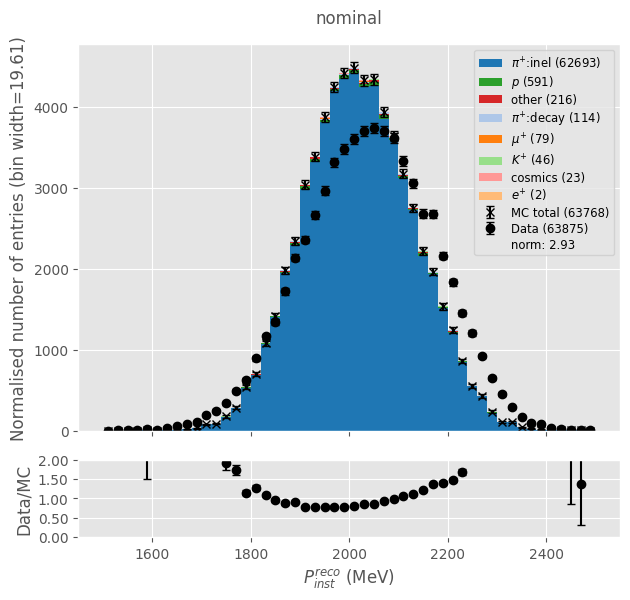

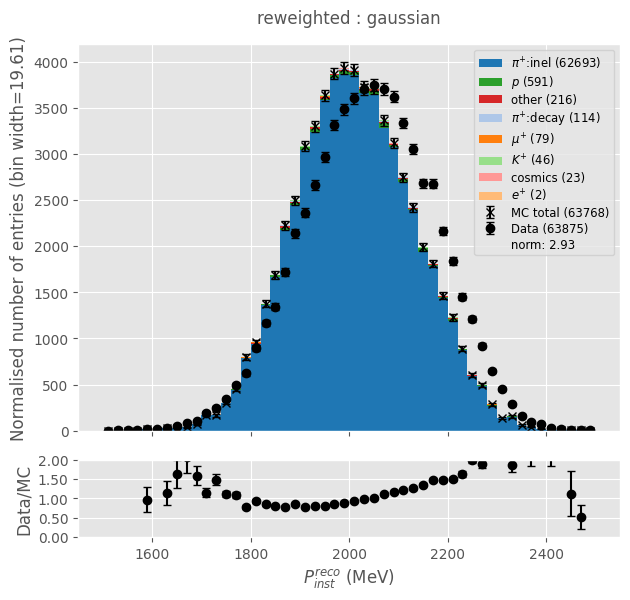

In [67]:
# Apply mirror weights to beam_filtered_samples
beam_weights = ReWeightResults(beam_filtered_samples["mc"],beam_filtered_samples["data"],args_pion, 50, results, 'gaussian', book = book, norm = 2.93)

In [317]:
ReWeightResults(pion_sample, args_pion, 50, results, smearing_results, book = book)

NameError: name 'pion_sample' is not defined

In [100]:
book.close()

pdf 2GeV_reweight.pdf has been closed


In [ ]:
reweight_params = {f"p{i}" : {"value" : results["gaussian"][0][i], "error" : results["gaussian"][1][i]} for i in range(cross_section.Fitting.gaussian.n_params)}

cross_section.SaveConfiguration("test/2GeV_reweight_params.json", reweight_params)


In [ ]:
weights = RatioWeights(pion_sample["mc"], "gaussian", results["gaussian"][0], 3)
smearing = np.random.normal(smearing_results[0][0], smearing_results[1][0], len(pion_sample["mc"].recoParticles.beam_inst_P))

energies = cex_beam_reweight.KEs(pion_sample, args_pion.upstream_loss_correction_params["value"], smearing)
energies_n = cex_beam_reweight.KEs(pion_sample, args_pion.upstream_loss_correction_params["value"], None)

'RecoDepositedEnergy' executed in 11.8810s

'RecoDepositedEnergy' executed in 49.6427s

'RecoDepositedEnergy' executed in 0.8552s

'RecoDepositedEnergy' executed in 2.3323s

In [101]:
print("nominal")
with Plots.PlotBook("pion_2GeV_nominal.pdf", True) as book:
    cex_beam_reweight.MakePlots(samples_pion["mc"], energies_n, cross_section.Tags.GenerateTrueBeamParticleTags, args_pion, None, None, book)
Plots.plt.show()

print("reweighted")
with Plots.PlotBook("pion_2GeV_reweight.pdf", True) as book:
    cex_beam_reweight.MakePlots(samples_pion["mc"], energies_n, cross_section.Tags.GenerateTrueBeamParticleTags, args_pion, weights, None, book)
Plots.plt.show()
# print("reweighted + smeared")
# with Plots.PlotBook("pion_2GeV_reweight_smear.pdf", True) as book:
#     cex_beam_reweight.MakePlots(pion_sample, energies, cross_section.Tags.GenerateTrueBeamParticleTags, args_pion, weights, smearing, book)
# Plots.plt.show()

nominal
pdf pion_2GeV_nominal.pdf has been opened
pdf pion_2GeV_nominal.pdf has been closed


AttributeError: module 'apps.cex_beam_reweight' has no attribute 'MakePlots'

# stopping muon reweight

In [ ]:
args_stopping_muon = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/cex_analysis_2GeV_stopping_muon_config.json"))
samples_stopping_muon = {"mc" : Master.Data(args_stopping_muon.mc_file, nTuple_type = args_stopping_muon.ntuple_type), "data" : Master.Data(args_stopping_muon.data_file, nTuple_type = args_stopping_muon.ntuple_type)}


In [ ]:
muon = cross_section.Particle.from_pdgid(-13)
true_fractional_range = stopping_muon_sample["mc"].trueParticles.beam_track_length / cross_section.BetheBloch.RangeFromKE(stopping_muon_sample["mc"].trueParticles.beam_KE_front_face, muon)

reco_fractional_range = cex_beam_reweight.RecoFractionalRange(stopping_muon_sample["mc"], muon, args_stopping_muon)
reco_fractional_range_data = cex_beam_reweight.RecoFractionalRange(stopping_muon_sample["data"], muon, args_stopping_muon)

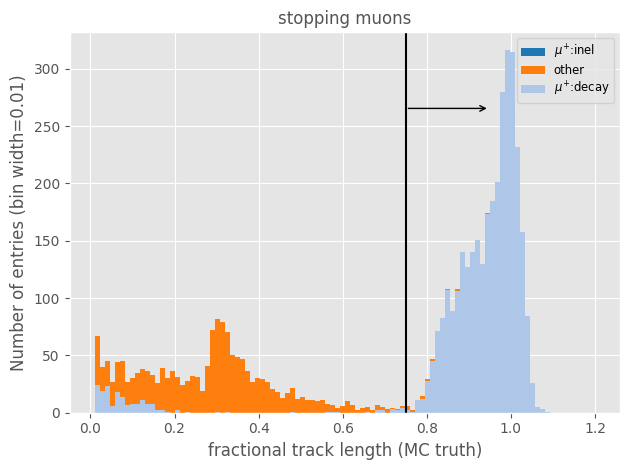

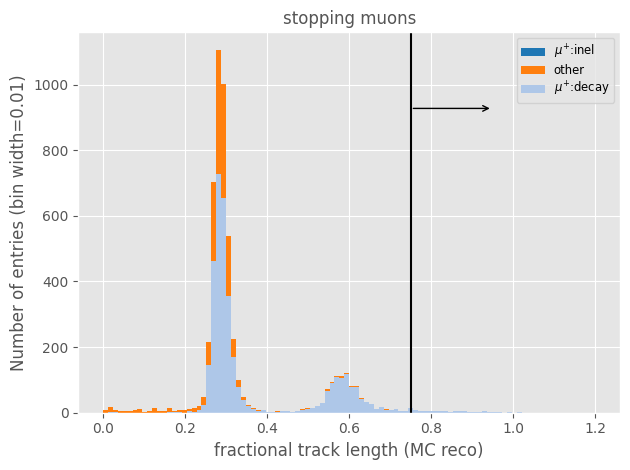

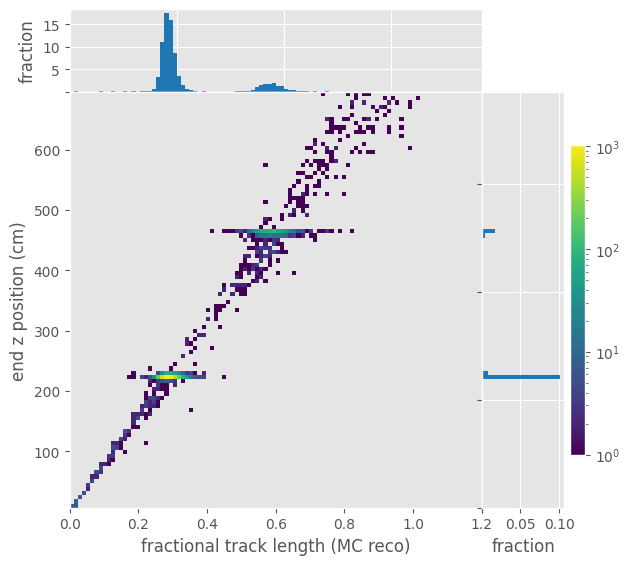

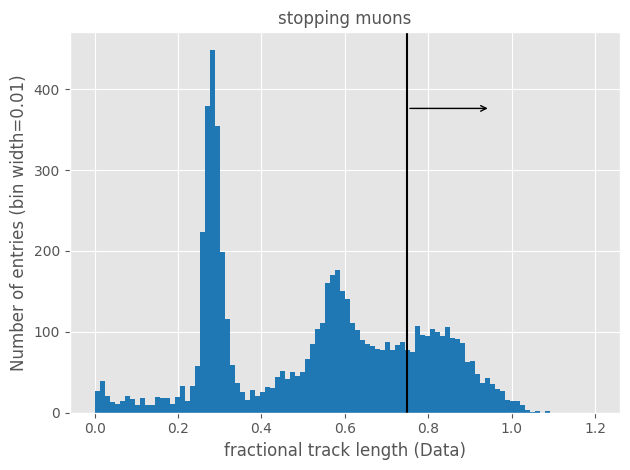

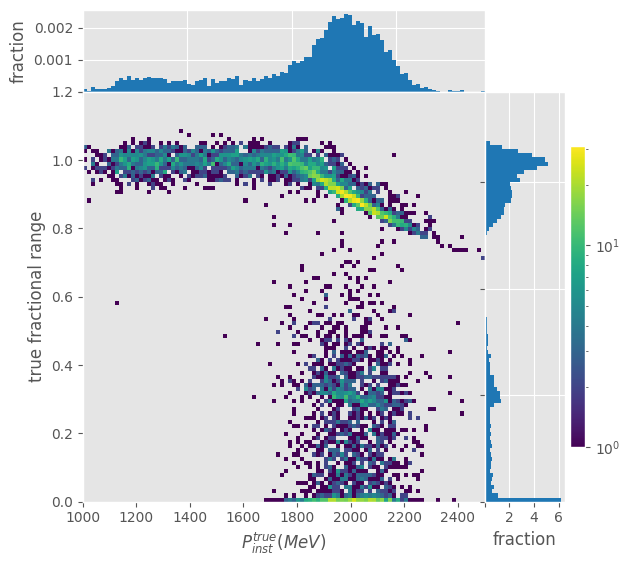

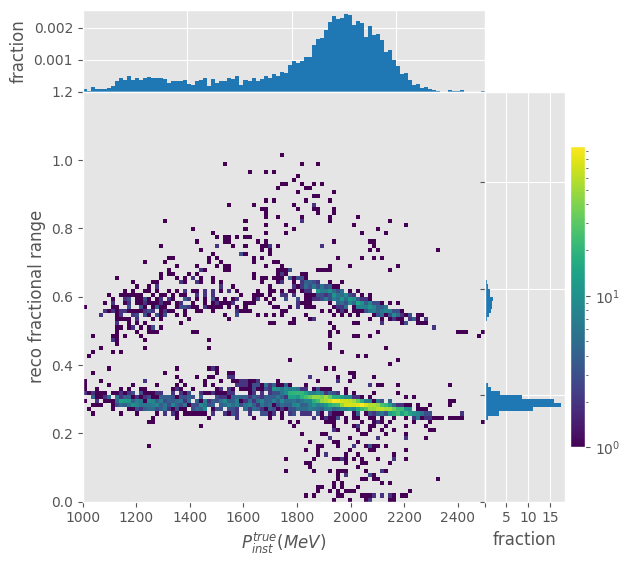

In [ ]:
stopping_muon_cut = 0.75 # 0.9 for 1GeV sample
with Plots.PlotBook("stopping_muon_selection.pdf", False) as book:
    Plots.PlotTagged(true_fractional_range, cross_section.Tags.StoppingMuonTag(stopping_muon_sample["mc"]), ncols = 1, x_range = [0.01, 1.2], x_label = "fractional track length (MC truth)", title = "stopping muons")
    Plots.DrawCutPosition(stopping_muon_cut, face = ">")
    book.Save()

    Plots.PlotTagged(reco_fractional_range, cross_section.Tags.StoppingMuonTag(stopping_muon_sample["mc"]), ncols = 1, x_range = [0, 1.2], x_label = "fractional track length (MC reco)", title = "stopping muons")
    Plots.DrawCutPosition(stopping_muon_cut, face = ">")
    book.Save()

    Plots.PlotHist2DMarginal(reco_fractional_range, stopping_muon_sample["mc"].recoParticles.beam_endPos_SCE.z, x_range = [0, 1.2], xlabel = "fractional track length (MC reco)", ylabel = "end z position (cm)")
    book.Save()

    Plots.PlotHist(reco_fractional_range_data, range = [0, 1.2], xlabel = "fractional track length (Data)", title = "stopping muons")
    Plots.DrawCutPosition(stopping_muon_cut, face = ">")
    book.Save()

    Plots.PlotHist2DMarginal(vector.magnitude(stopping_muon_sample["mc"].trueParticles.momentum[:, 0]), true_fractional_range, x_range = args_stopping_muon.P_inst_range, y_range = [0, 1.2], xlabel = "$P_{inst}^{true}(MeV)$", ylabel = "true fractional range")
    book.Save()

    Plots.PlotHist2DMarginal(vector.magnitude(stopping_muon_sample["mc"].trueParticles.momentum[:, 0]), reco_fractional_range, x_range = args_stopping_muon.P_inst_range, y_range = [0, 1.2], xlabel = "$P_{inst}^{true}(MeV)$", ylabel = "reco fractional range")
    book.Save()


In [ ]:
samples_stopping_muon_selected = {"mc" : stopping_muon_sample["mc"].Filter([reco_fractional_range > stopping_muon_cut], [reco_fractional_range > stopping_muon_cut], True), "data" : stopping_muon_sample["data"].Filter([reco_fractional_range_data > stopping_muon_cut], [reco_fractional_range_data > stopping_muon_cut], True)}

\begin{tabular}{llrrrrrrr}
 & Name & Remaining events & Percentage of total events remaining & Relative percentage events & Remaining PFOs & Percentage of total PFOs remaining & Relative percentage of PFOs & Average PFOs per event \\
0 & Initial data & 141548 & 100.000000 & 100.000000 & 422469 & 100.000000 & 100.000000 & 2.984634 \\
1 & - & 102443 & 72.373329 & 72.373329 & 339292 & 80.311692 & 80.311692 & 3.312008 \\
2 & - & 89274 & 63.069771 & 87.145047 & 324545 & 76.821021 & 95.653596 & 3.635381 \\
3 & - & 87403 & 61.747958 & 97.904205 & 317779 & 75.219484 & 97.915235 & 3.635791 \\
4 & - & 68113 & 48.120072 & 77.929819 & 242603 & 57.425042 & 76.343308 & 3.561772 \\
5 & - & 62390 & 44.076921 & 91.597786 & 222314 & 52.622559 & 91.636954 & 3.563295 \\
6 & - & 59944 & 42.348885 & 96.079500 & 215014 & 50.894622 & 96.716356 & 3.586914 \\
7 & - & 5267 & 3.720999 & 8.786534 & 15170 & 3.590796 & 7.055355 & 2.880197 \\
8 & - & 81 & 0.057224 & 1.537877 & 204 & 0.048288 & 1.344759 & 2.518519 \\


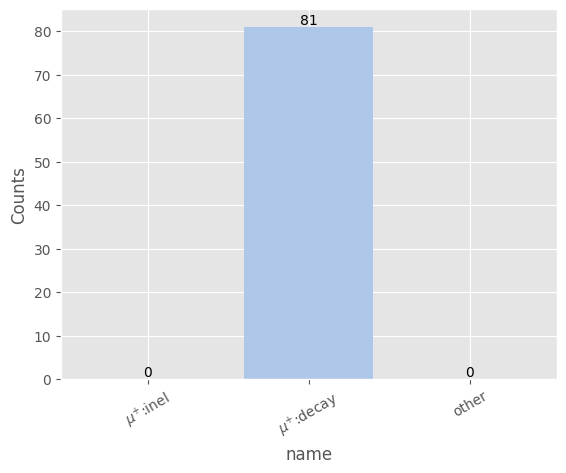

In [ ]:
print(samples_stopping_muon_selected["mc"].cutTable.get_table().style.to_latex())
print(samples_stopping_muon_selected["data"].cutTable.get_table().style.to_latex())
Plots.PlotTags(cross_section.Tags.StoppingMuonTag(samples_stopping_muon_selected["mc"]))

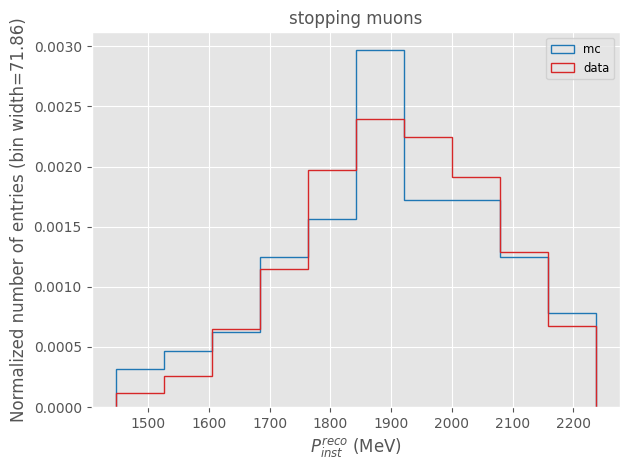

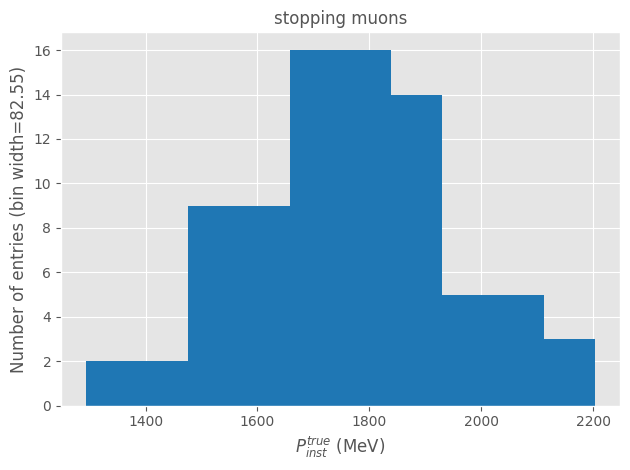

In [ ]:
book = Plots.PlotBook("reweight.pdf", False)

Plots.PlotHistComparison([s.recoParticles.beam_inst_P for s in samples_stopping_muon_selected.values()], labels = list(samples_stopping_muon_selected.keys()), bins = 10, xlabel = "$P_{inst}^{reco}$ (MeV)", colours = ["C0", "C6"], title = "stopping muons")
book.Save()

p_inst_true = vector.magnitude(samples_stopping_muon_selected["mc"].trueParticles.momentum[:, 0])

Plots.PlotHist(p_inst_true, xlabel = "$P_{inst}^{true}$ (MeV)", title = "stopping muons", bins = 10)
book.Save()

p=array([13.9284988 ,  0.87606849,  0.08422998])

p_err=array([2.15196786, 0.01069051, 0.00965206])

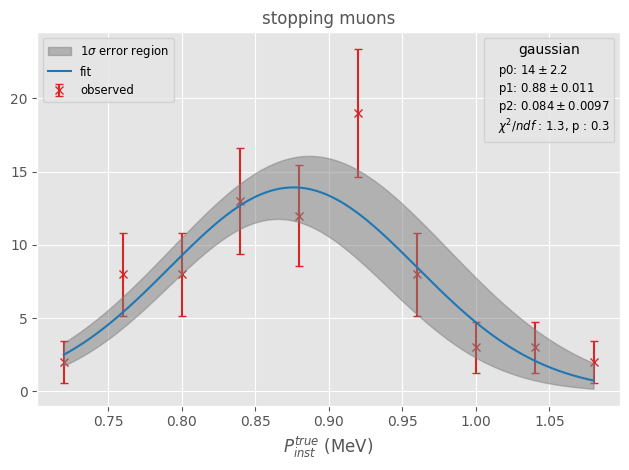

In [ ]:
true_params, true_params_err = cex_beam_reweight.GaussFit(p_inst_true/args_stopping_muon.beam_momentum, [1400/2000, 2200/2000], 10, book, "$P_{inst}^{true}$ (MeV)", "stopping muons")

In [ ]:
range_to_KE = cross_section.BetheBloch.interp_range_to_KE(2 * args_stopping_muon.beam_momentum)

18.469135802469136


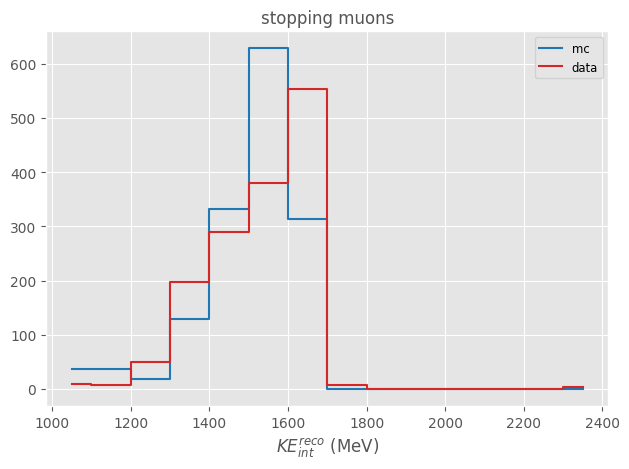

In [ ]:
# KE_ff_range_bins = np.linspace(args_stopping_muon.KE_inst_range[0], args_stopping_muon.KE_inst_range[1], 15)
KE_ff_range_bins = np.linspace(0.5 * args_stopping_muon.beam_momentum, 1.2 * args_stopping_muon.beam_momentum, 15)

KE_ff_range = {k :range_to_KE(v.recoParticles.beam_track_length) for k, v in samples_stopping_muon_selected.items()}

x = (KE_ff_range_bins[1:] + KE_ff_range_bins[:-1]) / 2
y = {k : np.histogram(np.clip(v, min(KE_ff_range_bins), max(KE_ff_range_bins)), KE_ff_range_bins)[0] for k, v in KE_ff_range.items()}

norm = len(samples_stopping_muon_selected["data"].eventNum)/len(samples_stopping_muon_selected["mc"].eventNum)
print(norm)

Plots.Plot(x, norm * y["mc"], style = "step", color = "C0", label = "mc")
Plots.Plot(x, y["data"], style = "step", color = "C6", label = "data", xlabel = "$KE^{reco}_{int}$ (MeV)", title = "stopping muons", newFigure = False)
book.Save()

In [ ]:
args = {
    "mu_0" : true_params[1],
    "sigma_0" : true_params[2],
    "bins" : KE_ff_range_bins,
    "norm" : norm,
    "p_inst_true" : p_inst_true/args_stopping_muon.beam_momentum,
    "KE_init_range" : KE_ff_range,
    }

result = minimize(cex_beam_reweight.Chi2KE, [true_params[1], true_params[2]], args = [args], method = "simplex")
print(result.minuit)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -0.8389                    │              Nfcn = 14               │
│ EDM = 0.0155 (Goal: 0.05)        │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

In [ ]:
{f"p{i}" : v for i, v in enumerate(result.minuit.values)}

{'p0': 0.970561490797886, 'p1': 0.07298674406543641}

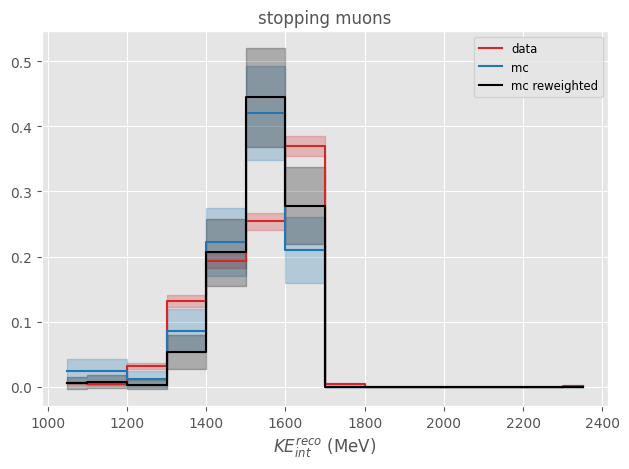

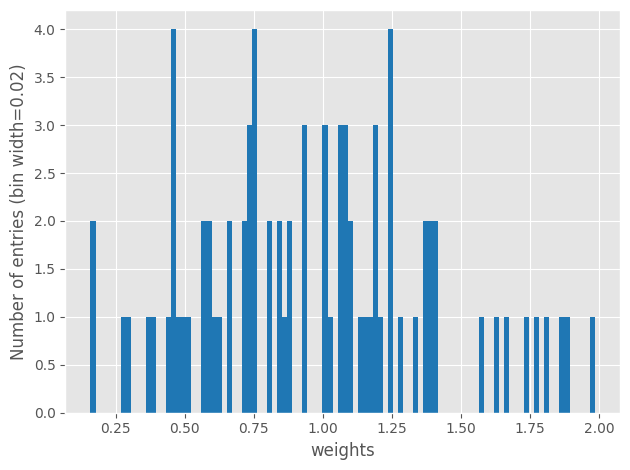

In [ ]:
weights_stopping_muon = cex_beam_reweight.Weights(args["p_inst_true"], result.x[0], result.x[1], true_params[1], true_params[2])

hist_data = np.histogram(np.clip(args["KE_init_range"]["data"], min(args["bins"]), max(args["bins"])), args["bins"])[0]
hist_mc = np.histogram(np.clip(args["KE_init_range"]["mc"], min(args["bins"]), max(args["bins"])), args["bins"])[0]
hist_mc_weighted = np.histogram(np.clip(args["KE_init_range"]["mc"], min(args["bins"]), max(args["bins"])), args["bins"], weights = weights_stopping_muon)[0]


x = (KE_ff_range_bins[1:] + KE_ff_range_bins[:-1]) / 2
Plots.Plot(x, hist_data / sum(hist_data), yerr = np.sqrt(hist_data) / sum(hist_data), style = "step", label = "data", color = "C6")
Plots.Plot(x, hist_mc / sum(hist_mc), yerr = np.sqrt(hist_mc) / sum(hist_mc), style = "step", label = "mc", color = "C0", newFigure = False)
Plots.Plot(x, hist_mc_weighted / sum(hist_mc_weighted), yerr = np.sqrt(hist_mc_weighted) / sum(hist_mc_weighted), style = "step", label = "mc reweighted", color = "k", xlabel = "$KE^{reco}_{int}$ (MeV)", title = "stopping muons", newFigure = False)
book.Save()
Plots.PlotHist(weights_stopping_muon, xlabel = "weights")
book.Save()

p=array([  30.54147187, 1938.24420872,  164.26965874])

p_err=array([ 4.38499517, 19.1765701 , 14.38128157])

p=array([ 571.66465859, 1922.22856964,  173.96244622])

p_err=array([18.38526997,  4.57829454,  3.42473638])

p=array([  30.92139304, 1910.81367029,  164.51550481])

p_err=array([ 4.43429032, 19.09868488, 14.48449828])

p=array([ 571.66465859, 1922.22856964,  173.96244622])

p_err=array([18.38526997,  4.57829454,  3.42473638])

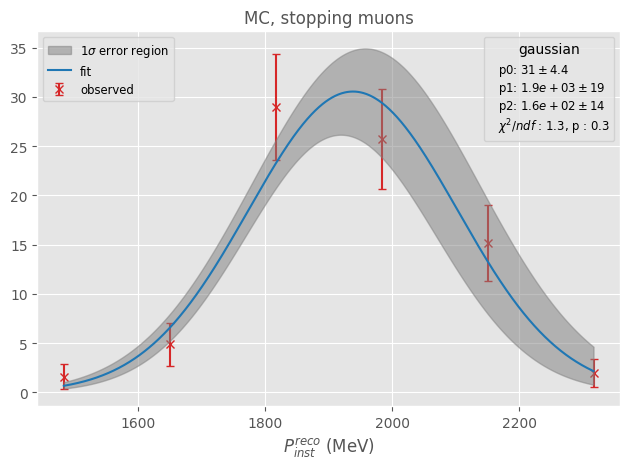

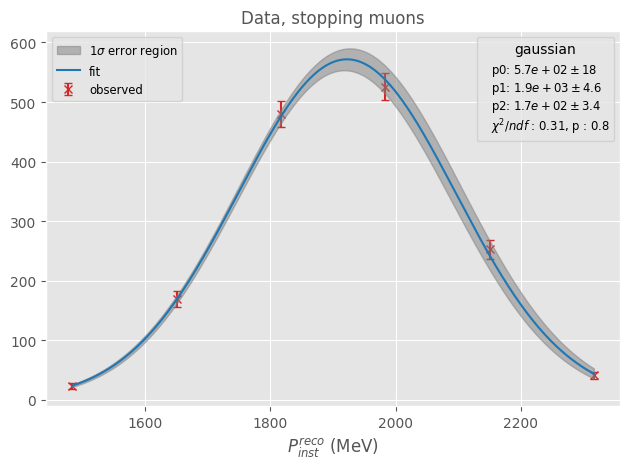

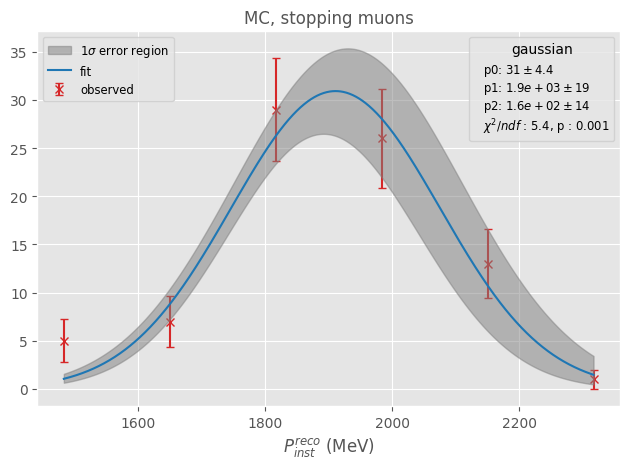

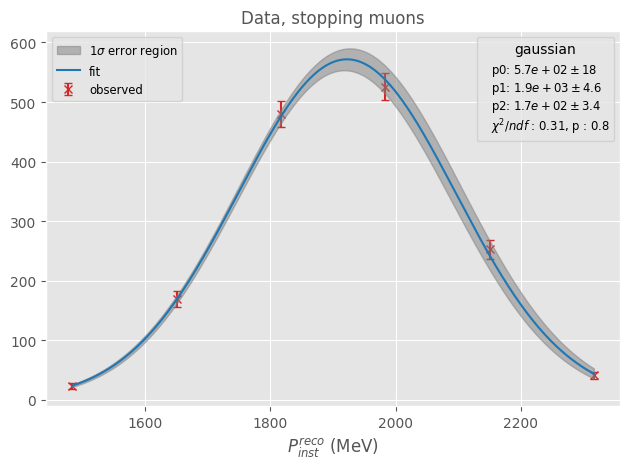

In [ ]:
# p_range = [0.8 * args_stopping_muon.beam_momentum, 1.2 * args_stopping_muon.beam_momentum]
p_range = [1400, 2400]
bins = 6

smearing_mu_rw, smearing_sigma_rw, _, _  = cex_beam_reweight.Smearing(samples_stopping_muon_selected["mc"].recoParticles.beam_inst_P, samples_stopping_muon_selected["data"].recoParticles.beam_inst_P, bins, p_range, book, weights_stopping_muon)
smearing_mu, smearing_sigma, _, _  = cex_beam_reweight.Smearing(samples_stopping_muon_selected["mc"].recoParticles.beam_inst_P, samples_stopping_muon_selected["data"].recoParticles.beam_inst_P, bins, p_range, book)
book.close()

In [ ]:
print(smearing_mu, smearing_sigma)
print(smearing_mu_rw, smearing_sigma_rw)

smearing_params = {"mu" : {"value" : smearing_mu[0], "error" : smearing_mu[1]}, "sigma" : {"value" : smearing_sigma[0], "error" : smearing_sigma[1]}}

print(smearing_params)

[11.414899351632812, 19.63976947678757] [56.54716059656925, 43.437603926909794]
[-16.01563908444018, 19.7155172839746] [57.257417960564794, 42.55124763724436]
{'mu': {'value': 11.414899351632812, 'error': 19.63976947678757}, 'sigma': {'value': 56.54716059656925, 'error': 43.437603926909794}}


In [ ]:
smearing_stopping_muon = np.random.normal(smearing_mu[0], smearing_sigma[0], len(samples_stopping_muon_selected["mc"].eventNum))
smearing_stopping_muon_rw = np.random.normal(smearing_mu_rw[0], smearing_sigma_rw[0], len(samples_stopping_muon_selected["mc"].eventNum))

# weights_stopping_muon = Weights(vector.magnitude(pion_sample["mc"].trueParticles.momentum[:, 0]), result.x[0], result.x[1], true_params[1], true_params[2])
reco_KE_unsmeared_sm = cex_beam_reweight.KEs(samples_stopping_muon_selected, args_stopping_muon.upstream_loss_correction_params["value"])
reco_KE_smeared_sm = cex_beam_reweight.KEs(samples_stopping_muon_selected, args_stopping_muon.upstream_loss_correction_params["value"], smearing_stopping_muon)
reco_KE_smeared_sm_rw = cex_beam_reweight.KEs(samples_stopping_muon_selected, args_stopping_muon.upstream_loss_correction_params["value"], smearing_stopping_muon_rw)

'RecoDepositedEnergy' executed in 0.1239s

'RecoDepositedEnergy' executed in 0.3758s

'RecoDepositedEnergy' executed in 0.1466s

'RecoDepositedEnergy' executed in 0.3800s

'RecoDepositedEnergy' executed in 0.1251s

'RecoDepositedEnergy' executed in 0.3914s

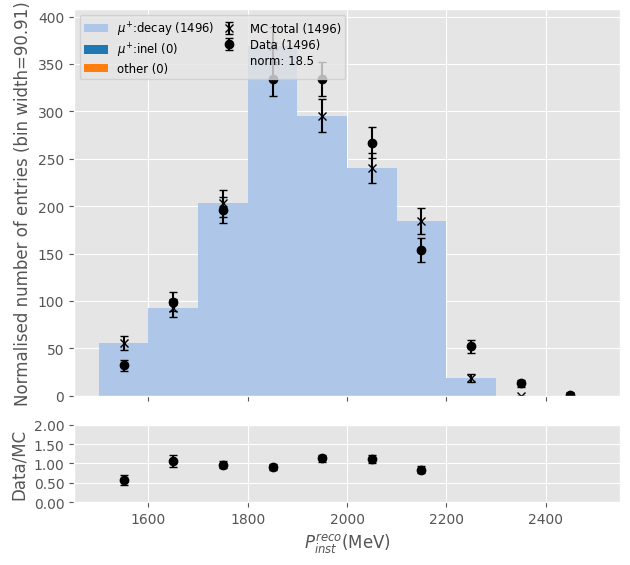

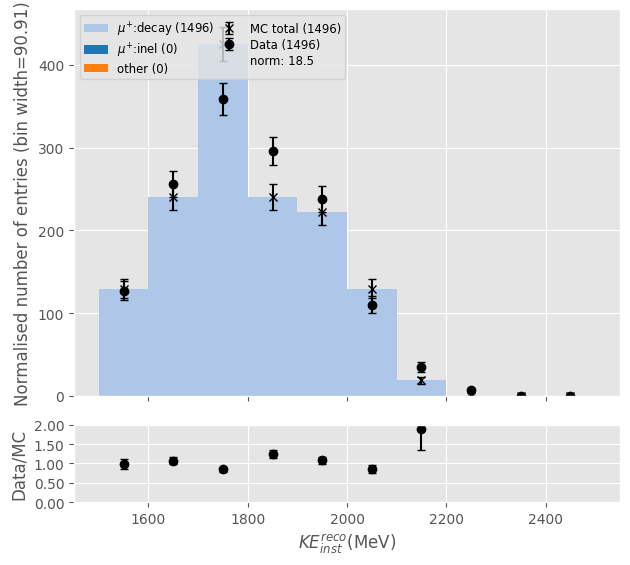

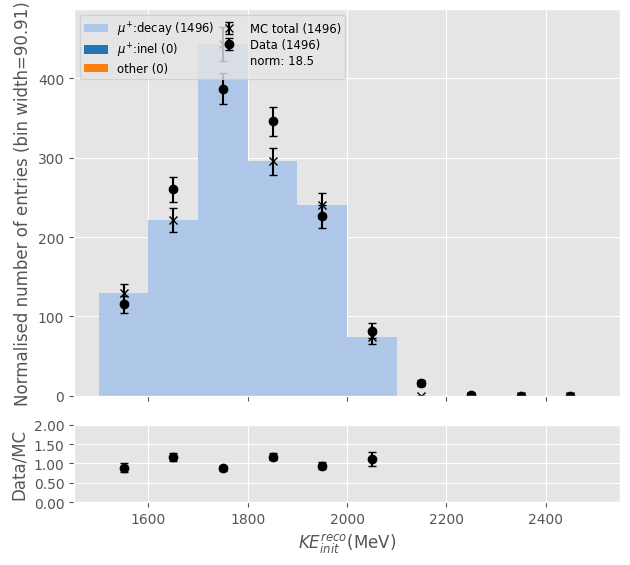

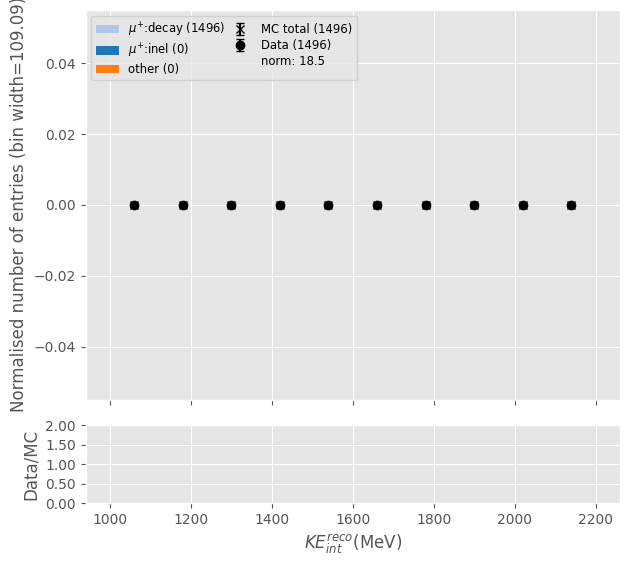

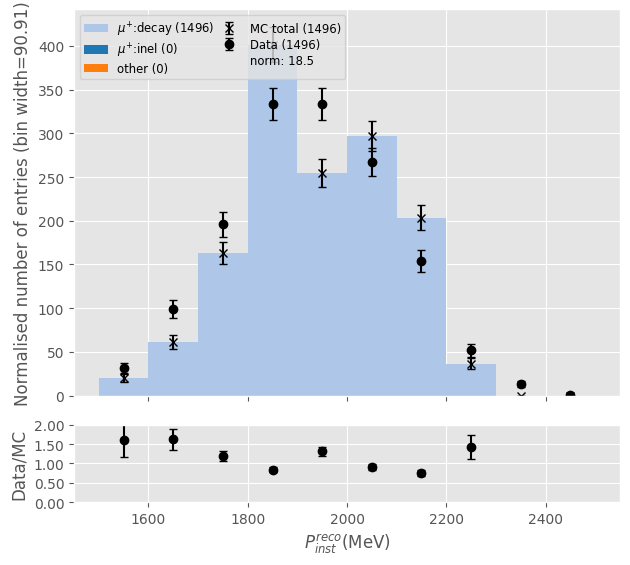

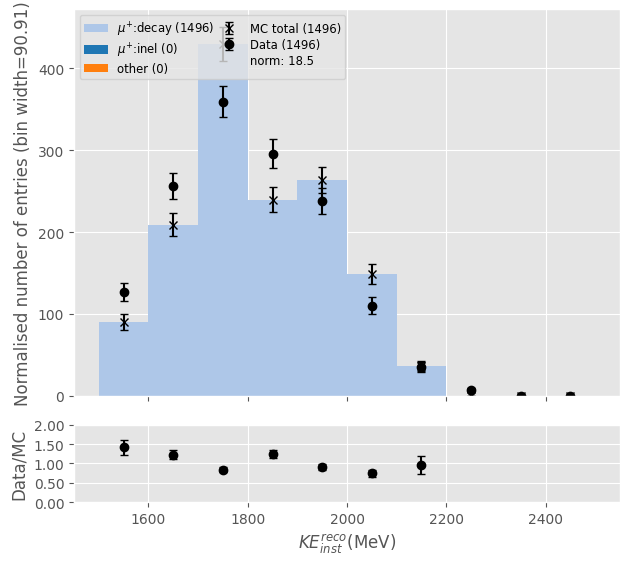

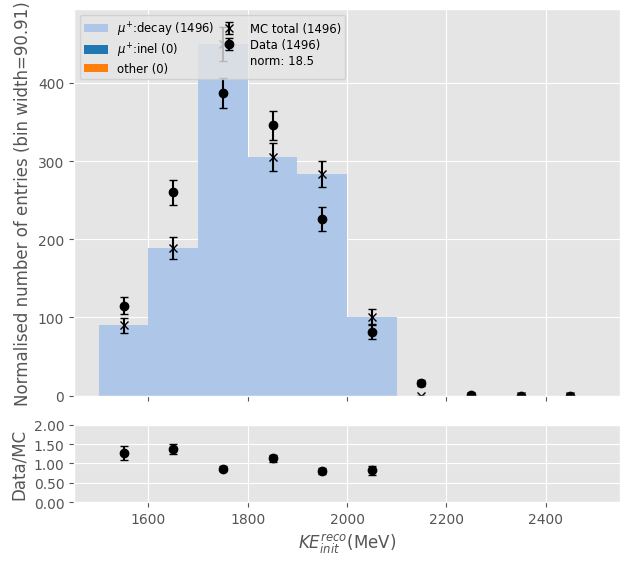

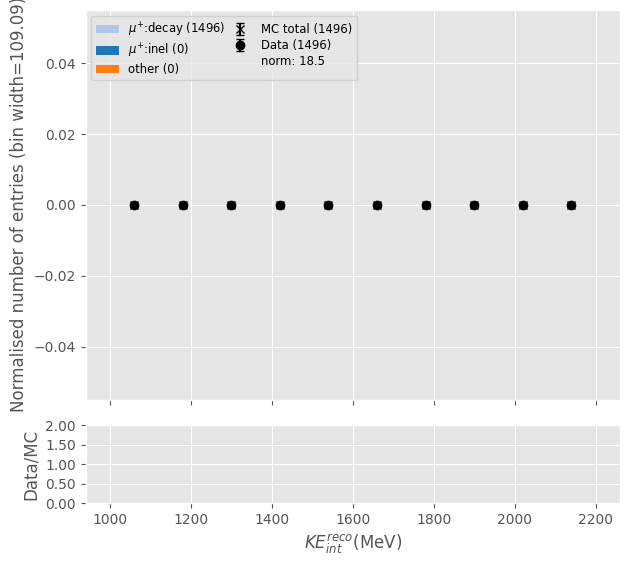

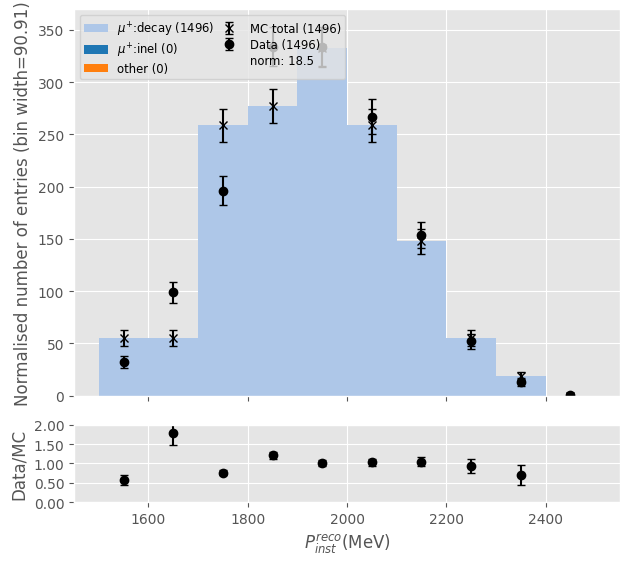

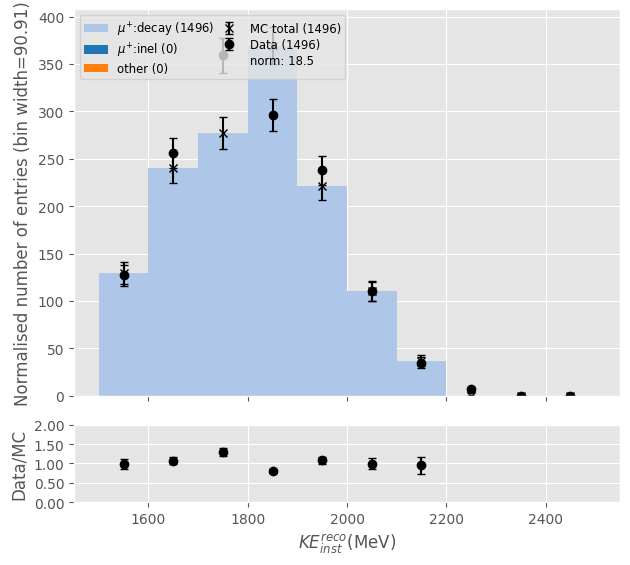

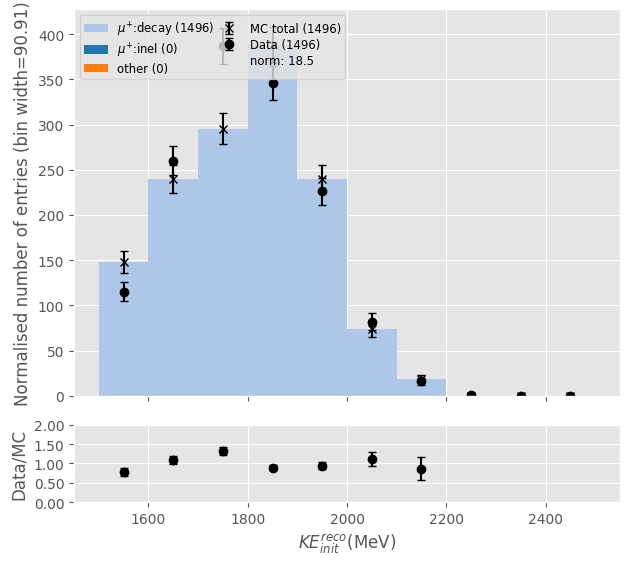

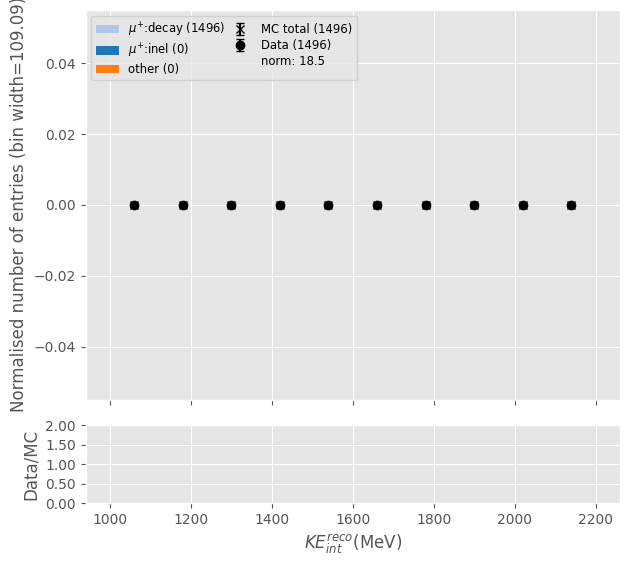

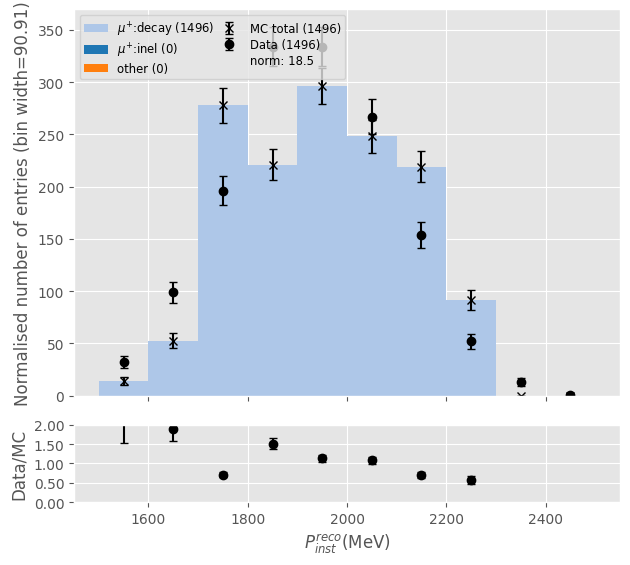

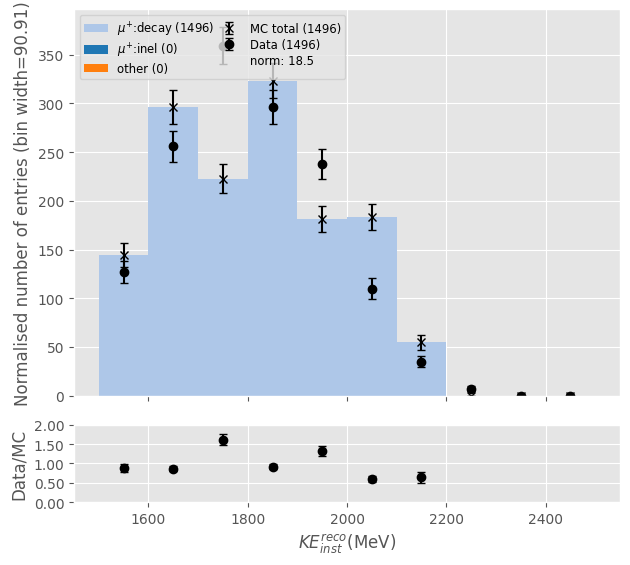

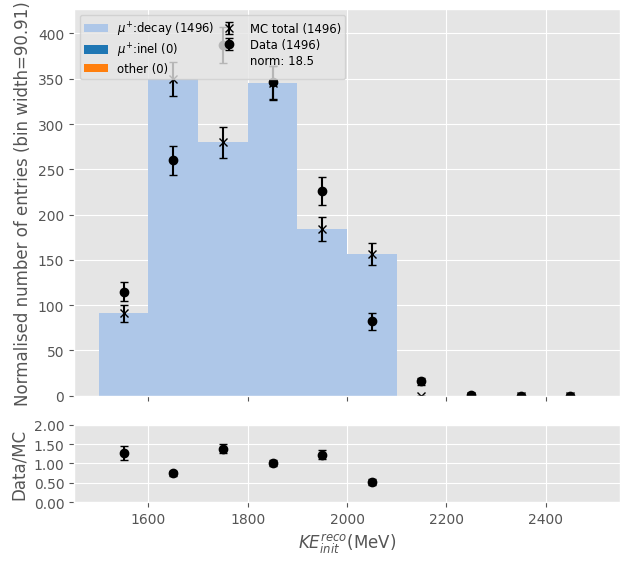

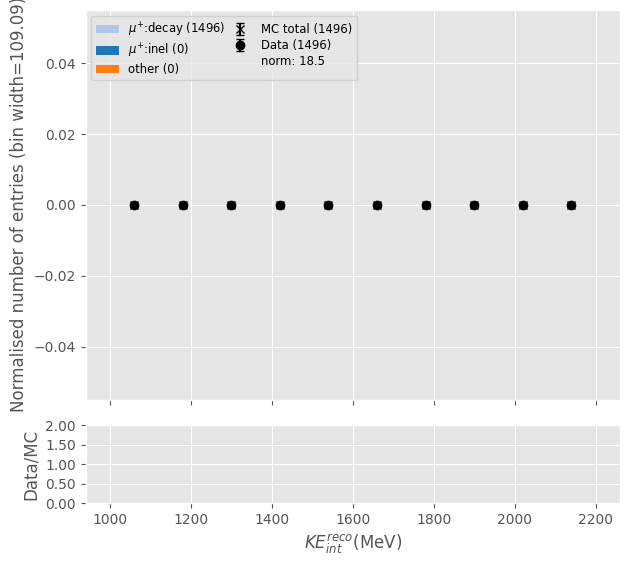

In [ ]:
with Plots.PlotBook("stopping_muon_nominal.pdf", False) as book:
    cex_beam_reweight.MakePlots(samples_stopping_muon_selected, reco_KE_unsmeared_sm, cross_section.Tags.StoppingMuonTag, args_stopping_muon, None, None, book, 10)

with Plots.PlotBook("stopping_muon_reweight.pdf", False) as book:
    cex_beam_reweight.MakePlots(samples_stopping_muon_selected, reco_KE_unsmeared_sm, cross_section.Tags.StoppingMuonTag, args_stopping_muon, weights_stopping_muon, None, book, 10)

with Plots.PlotBook("stopping_muon_smeared.pdf", False) as book:
    cex_beam_reweight.MakePlots(samples_stopping_muon_selected, reco_KE_smeared_sm, cross_section.Tags.StoppingMuonTag, args_stopping_muon, None, smearing_stopping_muon, book, 10)

with Plots.PlotBook("stopping_muon_reweight_smeared.pdf", False) as book:
    cex_beam_reweight.MakePlots(samples_stopping_muon_selected, reco_KE_smeared_sm_rw, cross_section.Tags.StoppingMuonTag, args_stopping_muon, weights_stopping_muon, smearing_stopping_muon_rw, book, 10)

In [ ]:
smearing_mc_pions = np.random.normal(smearing_mu[0], smearing_sigma[0], len(pion_sample["mc"].eventNum))
smearing_mc_pions_rw = np.random.normal(smearing_mu_rw[0], smearing_sigma_rw[0], len(pion_sample["mc"].eventNum))
weights_pion_sample = cex_beam_reweight.Weights(vector.magnitude(pion_sample["mc"].trueParticles.momentum[:, 0])/args_pion.beam_momentum, result.x[0], result.x[1], true_params[1], true_params[2])

reco_KE_unsmeared = cex_beam_reweight.KEs(pion_sample, args_pion.upstream_loss_correction_params["value"])
reco_KE_smeared = cex_beam_reweight.KEs(pion_sample, args_pion.upstream_loss_correction_params["value"], smearing_mc_pions)
reco_KE_smeared_rw = cex_beam_reweight.KEs(pion_sample, args_pion.upstream_loss_correction_params["value"], smearing_mc_pions_rw)


'RecoDepositedEnergy' executed in 13.7160s

: 

nominal


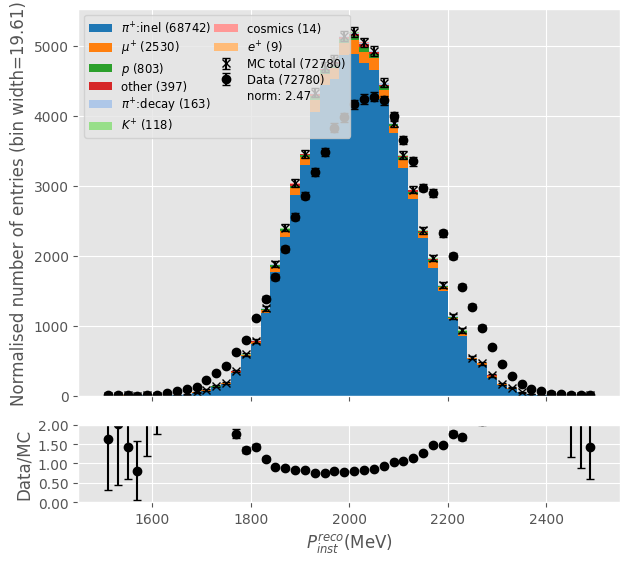

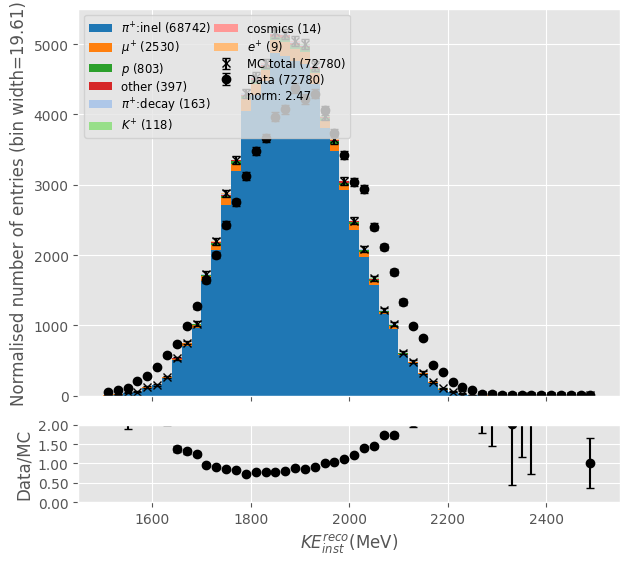

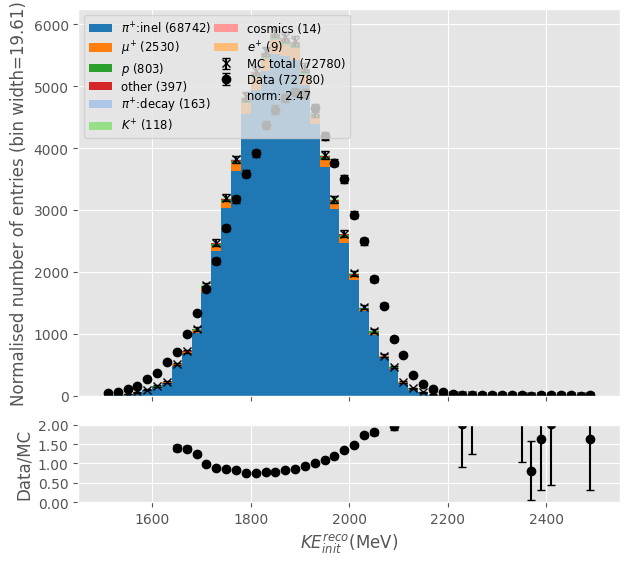

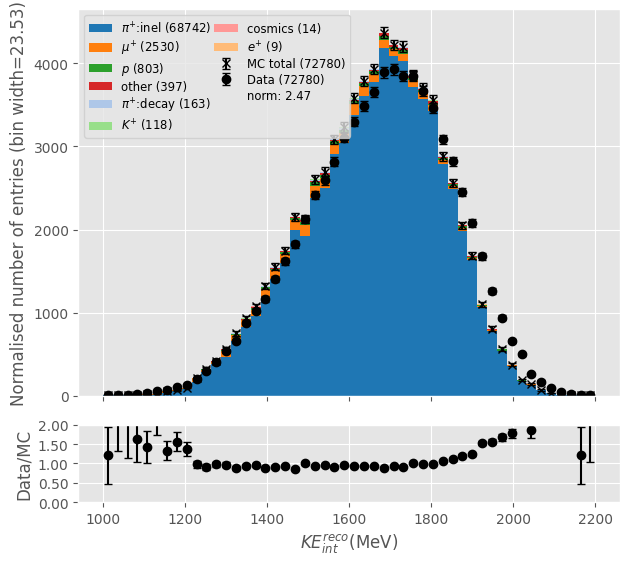

reweighted


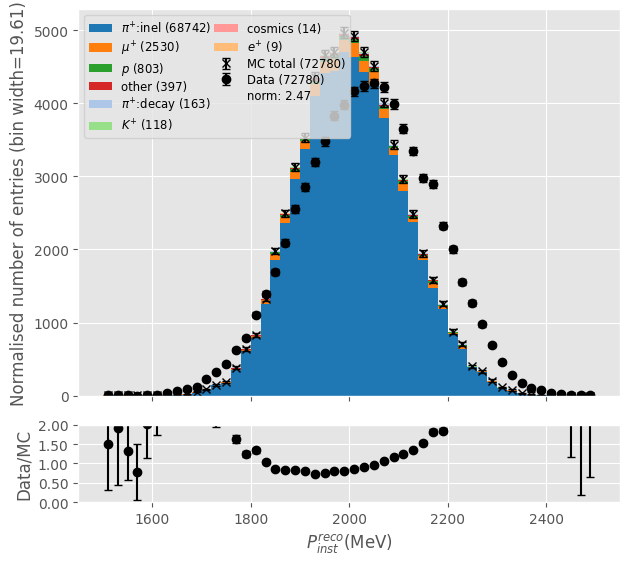

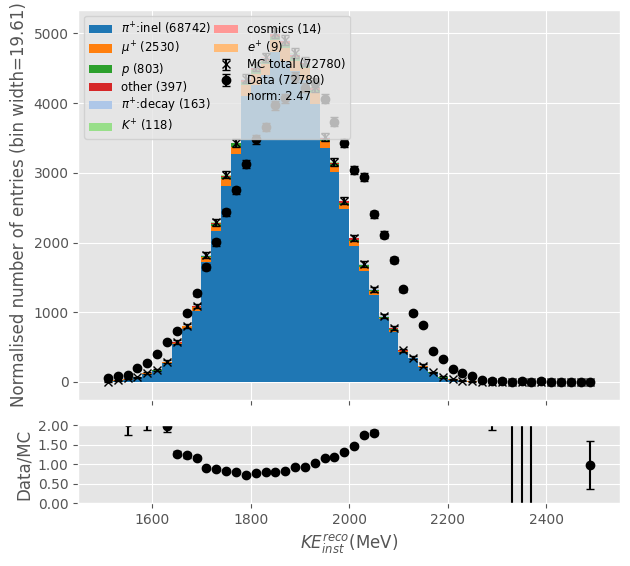

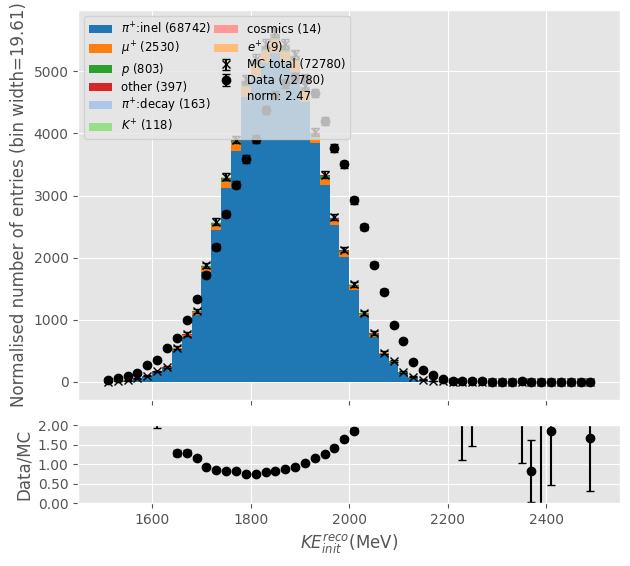

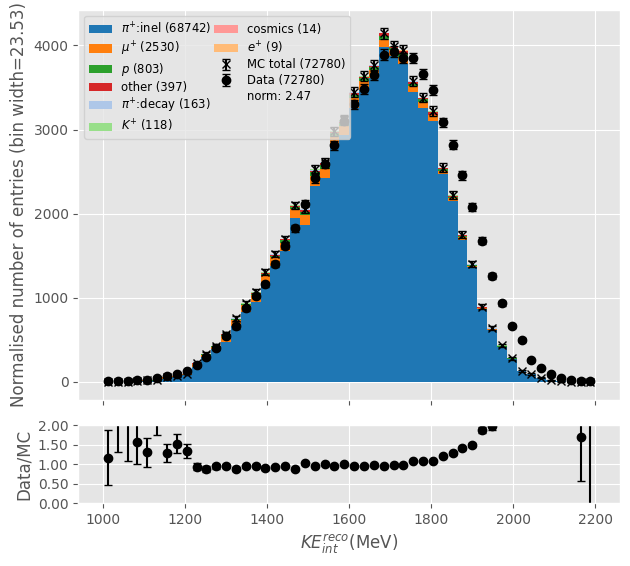

smeared


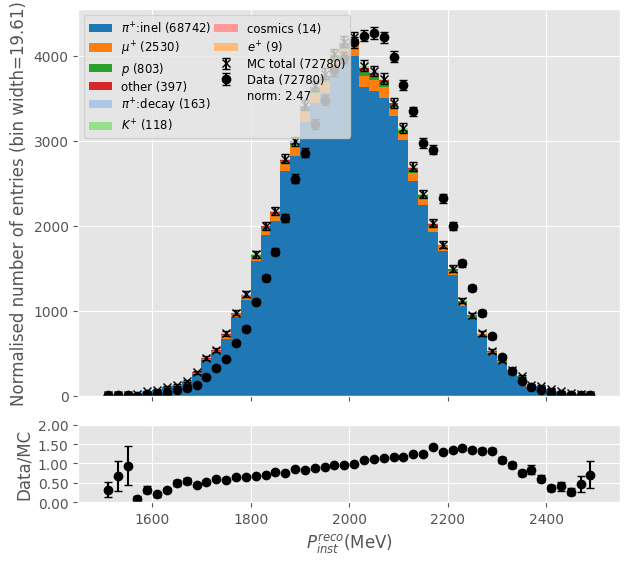

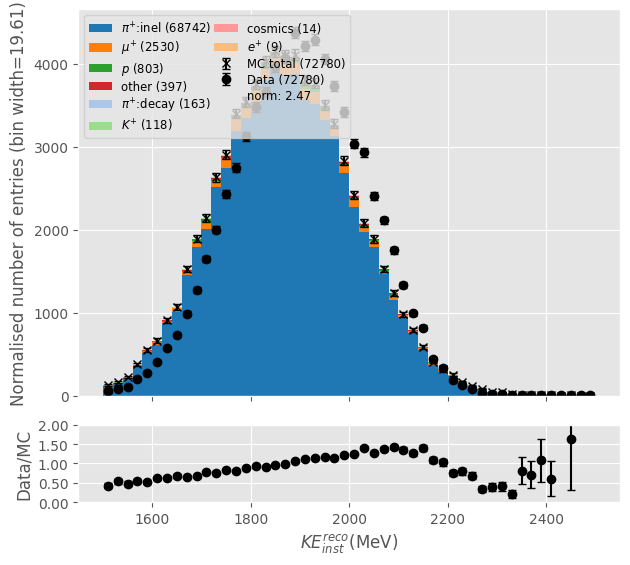

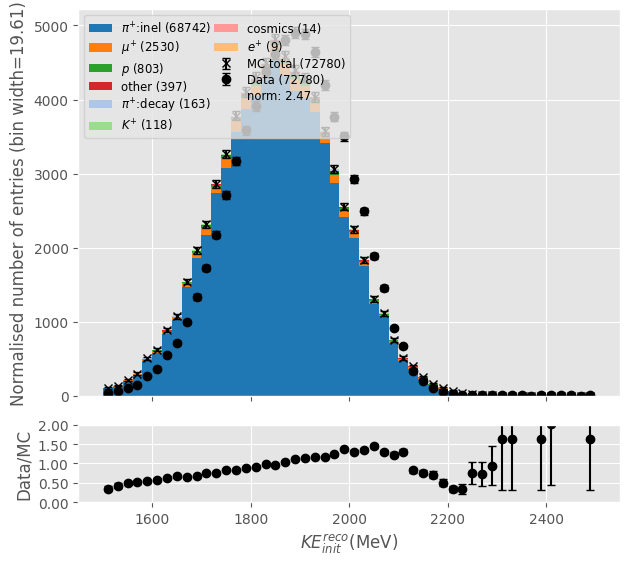

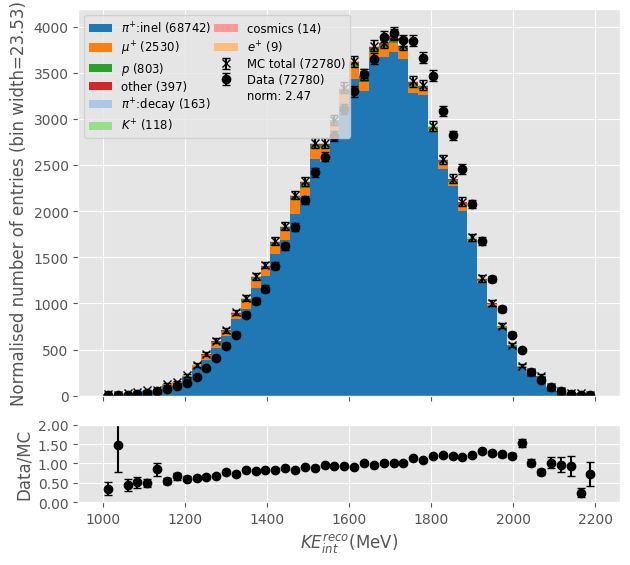

reweight + smeared


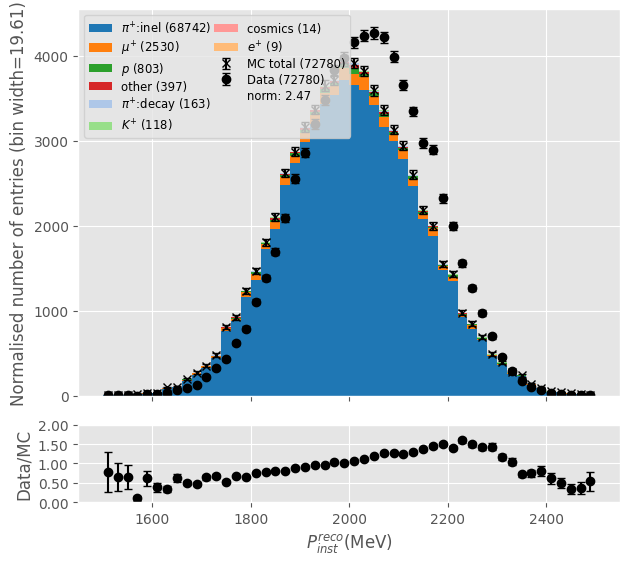

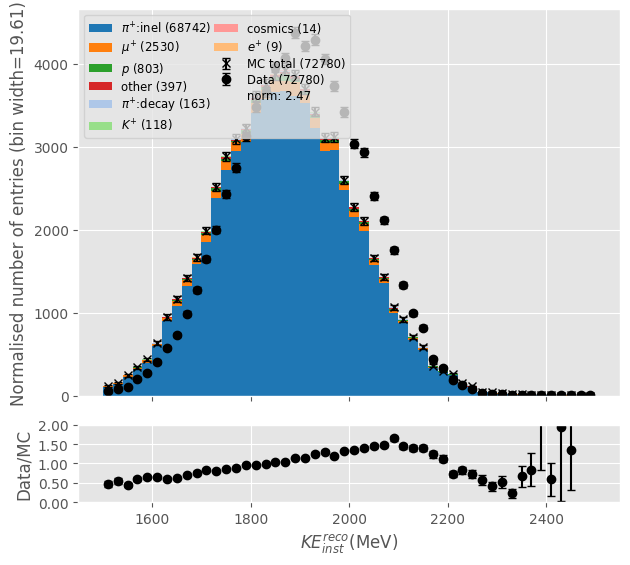

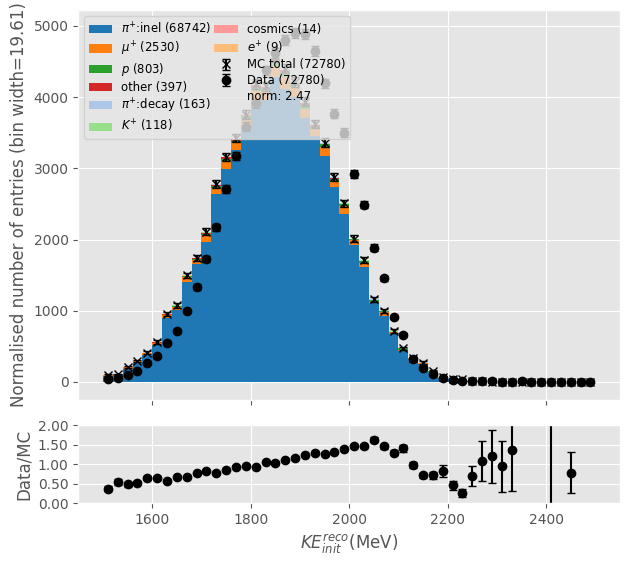

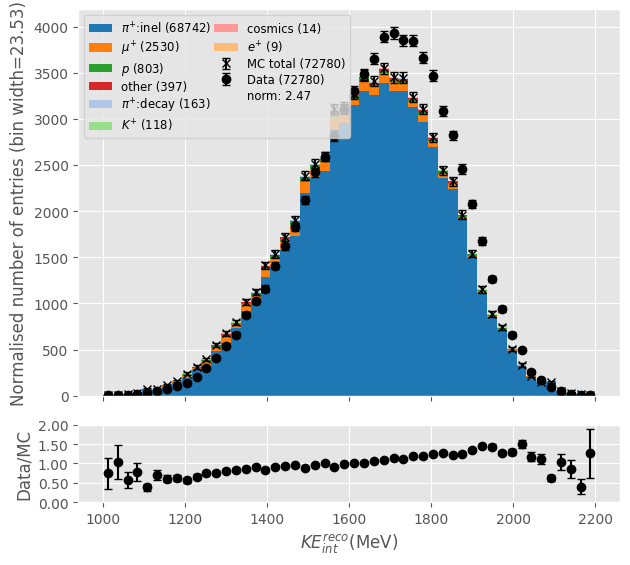

In [ ]:
print("nominal")
with Plots.PlotBook("pion_nominal.pdf", False) as book:
    cex_beam_reweight.MakePlots(pion_sample, reco_KE_unsmeared, cross_section.Tags.GenerateTrueBeamParticleTags, args_pion, None, None, book)
Plots.plt.show()

print("reweighted")
with Plots.PlotBook("pion_reweight.pdf", False) as book:
    cex_beam_reweight.MakePlots(pion_sample, reco_KE_unsmeared, cross_section.Tags.GenerateTrueBeamParticleTags, args_pion, weights_pion_sample, None, book)
Plots.plt.show()

print("smeared")
with Plots.PlotBook("pion_smeared.pdf", False) as book:
    cex_beam_reweight.MakePlots(pion_sample, reco_KE_smeared, cross_section.Tags.GenerateTrueBeamParticleTags, args_pion, None, smearing_mc_pions, book)
Plots.plt.show()

print("reweight + smeared")
with Plots.PlotBook("pion_reweight_smeared.pdf", False) as book:
    cex_beam_reweight.MakePlots(pion_sample, reco_KE_smeared_rw, cross_section.Tags.GenerateTrueBeamParticleTags, args_pion, weights_pion_sample, smearing_mc_pions_rw, book)
Plots.plt.show()
